## Final Model Result Plots
* Sangwon Baek
* March 10th, 2023

In [1]:
import pandas as pd
import numpy as np
import re
import random as rn
import statistics 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kstest, norm, mannwhitneyu, chi2_contingency, fisher_exact, ttest_ind, zscore

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score, ParameterGrid, StratifiedKFold, KFold
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, f1_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from statsmodels.stats.proportion import proportion_confint

from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
import shap

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, auc
from sklearn import metrics
from sklearn.neighbors import KernelDensity
from statsmodels.stats import contingency_tables
import statsmodels.api as sm
from scipy import integrate
from scipy.integrate import quad

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

from decimal import Decimal

import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow.keras.backend as K
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib.ticker import FuncFormatter


C:\Users\user\anaconda3\envs\swb_env_3.9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Read csv file using pandas
df2 = pd.read_csv('../Data/Preprocessed/CRF_Initial.csv', low_memory=False)
df2 = df2.drop(columns='Unnamed: 0')

na_cols = ['UD_HT','UD_DM','UD_CVD','UD_cancer','UD_other','SMT_fever','SMT_cough','SMT_sputum','SMT_dyspnea',
          'SMT_myalgia', 'SMT_sorethroat', 'SMT_mental', 'SMT_GI', 'steroid']
df2[na_cols] = df2[na_cols].fillna(value=0)

#Remove D-Dimer from the dataframe
ColumnNames = ['No', 'ID', 'age', 'sex', 'dx_date', 'hospitalized_date', 'UD_HT', 'UD_DM', 'UD_CVD', 'UD_cancer',
              'UD_other', 'SMT_fever', 'SMT_cough', 'SMT_sputum', 'SMT_dyspnea', 'SMT_myalgia',
              'SMT_sorethroat', 'SMT_mental', 'SMT_GI', 'TX_0', 'TX_1', 'TX_2', 'TX_3', 'TX_4', 
               'Smoking_0', 'Smoking_1', 'Smoking_2', 'Smoking_3', 'BT', 'SBP', 
               'DBP', 'PR', 'RR', 'SPO2', 'WBC', 'ANC', 'ALC', 'PLT', 'CRP', 'LDH', 
               'DD', 'PCR', 'steroid', 'Mild','Moderate','Severe']
df2 = df2[ColumnNames].drop(columns = 'DD')

#Replace names of UD and SMT without them. 
# Replace 'UD_' and 'SMT_' in the column names
new_column_names = {col: col.replace('UD_', '').replace('SMT_', '') for col in df2.columns}

# Rename the columns in the dataframe
df2 = df2.rename(columns=new_column_names)

#Separate DF into validation and developmentsets
DevelopmentSet = df2.loc[~df2['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU'])]
ValidationSet = df2.loc[df2['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU'])]

### Data Conversion / Normalization / Train Test Split

In [3]:
def data_preprocessor(train_dataset, test_dataset, columnList, outcome):
    #Create train and test set
    X_train = train_dataset[columnList].values
    X_test = test_dataset[columnList].values
    Y_train = train_dataset[outcome].values.ravel()
    Y_test = test_dataset[outcome].values.ravel()
    
    #Apply StandardScaler Normalization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
        
    return X_train, X_test, Y_train, Y_test

In [4]:
def Compute_CI(values):    
    sample_mean = np.mean(values)
    # ddof=1 to compute sample standard deviation
    sample_std = np.std(values, ddof=1) 
    
    # for a 95% confidence interval
    z_value = norm.ppf(0.975)  
    ci_lower = sample_mean - z_value * (sample_std / np.sqrt(len(values)))
    ci_upper = sample_mean + z_value * (sample_std / np.sqrt(len(values)))
    return [ci_lower, ci_upper]

In [5]:
#List of Columns 
outcome = ['Severe']
#ALL Variables
Variables_0 = ['age', 'sex', 'HT', 'DM', 'CVD', 'cancer', 'other',
               'fever', 'cough', 'sputum', 'dyspnea', 'myalgia', 'sorethroat', 'mental', 'GI', 
               'BT', 'SBP', 'DBP', 'PR', 'RR', 'SPO2', 'WBC', 'ANC', 'ALC', 'PLT', 'CRP', 'LDH']

#Select the variables that commonly appear among 6 selection techniques based on selection probability.
#Available Selection Probabilities exceeding 50%  
#{1}_{2}_{3}_V{4} : 1=Selection Probability, 2=Top cutoff, 3=Variable Numbers, 4=Version when same (default: 1)

#5
Variables_1 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR']
Variables_2 = ['CRP', 'LDH', 'ALC', 'ANC', 'dyspnea']

#6
Variables_3 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea']
Variables_4 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'WBC']
Variables_5 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'PLT']

#7 
Variables_6 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC']
Variables_7 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'PLT']
Variables_8 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'SPO2']

#8
Variables_9 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age']
Variables_10 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2']
Variables_11 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'DBP']

#9
Variables_12 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2']
Variables_13 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'DBP']
Variables_14 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PR']
Variables_15 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'BT']

#10
Variables_16 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP']
Variables_17 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PR']
Variables_18 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'BT']
Variables_19 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'SBP']
Variables_20 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DM']
Variables_21 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT']
Variables_22 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP']

#11
Variables_23 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PR']
Variables_24 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'BT']
Variables_25 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'SBP']
Variables_26 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'DM']
Variables_27 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PLT']
Variables_28 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'PR', 'BT']
Variables_29 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'PR', 'SBP']
Variables_30 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'PR', 'DM']
Variables_31 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'PR', 'PLT']
Variables_32 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PLT', 'BT', 'DBP']
Variables_33 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PLT', 'BT', 'PR']
Variables_34 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PLT', 'BT', 'SBP']
Variables_35 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PLT', 'BT', 'DM']
Variables_36 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PLT', 'BT', 'SPO2']
Variables_37 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'PR']
Variables_38 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'BT']
Variables_39 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'SBP']
Variables_40 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'DM']
Variables_41 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'DBP']
Variables_42 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'SBP', 'PR']
Variables_43 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'SBP', 'DM']
Variables_44 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'SBP', 'PLT']
Variables_45 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'BT', 'PR']
Variables_46 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'BT', 'DM']
Variables_47 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'BT', 'SBP']
Variables_48 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DM', 'PR']
Variables_49 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'DBP', 'SBP', 'PR']
Variables_50 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'DBP', 'SBP', 'DM']

#12
Variables_51 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PLT', 'BT']
Variables_52 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PLT', 'SBP']
Variables_53 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PLT', 'DM']
Variables_54 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PLT', 'PR']
Variables_55 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'SBP', 'BT']
Variables_56 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'SBP', 'DM']
Variables_57 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'SBP', 'PR']
Variables_58 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'SBP', 'PR', 'BT']
Variables_59 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'SBP', 'PR', 'PLT']

#13
Variables_60 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'SBP','DM', 'BT']

Num_Variables = 60

In [6]:
#Preprocess dataset based on columnList
for i in range (Num_Variables):
    exec(f"X{i}_train, X{i}_test, Y{i}_train, Y{i}_test = data_preprocessor(DevelopmentSet, ValidationSet, Variables_{i}, outcome)")

### DL & ML Model Internal Validation

In [7]:
#Hyperparameters and spaces for putting results
def Internal_Validation_DNN_BootALL(X, Y):
    
    #Define empty lists to store result values
    SENSITIVITY_list, SPECIFICITY_list = [], [] 
    AUC_list, PRAUC_list, F1_list = [], [], []
    NPV_list, PPV_list, LRP_list, LRN_list, DOR_list = [], [], [], [], []
    OT_list = [] 
    
    N = 5 
    
    #Run Cross-Validation for 5 times 
    for i in range (N):
        #Define random_state, Stratified K-Fold
        random_state = 0 
        skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
        
        #Define empty lists to store result values
        sensitivity_list, specificity_list = [], [] 
        auc_list, prauc_list, f1_list = [], [], []
        npv_list, ppv_list, lrp_list, lrn_list, dor_list = [], [], [], [], []
        ot_list = [] 
        
        #Define earlyStopping, lr_scheduler
        earlyStopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=1)  
            
        for train, val in skfold.split(X, Y):
            #Split Development dataset into Train/Test 
            X_train = X[train]
            Y_train = Y[train]
            X_val = X[val]
            Y_val = Y[val]

            #Reset Tensorflow
            np.random.seed(random_state)
            rn.seed(random_state)
            tf.random.set_seed(random_state)
            tf.compat.v1.set_random_seed(random_state)
            tf.keras.initializers.Zeros()

            #DNN Final Model Building with 8:2 validation datset 
            model = Sequential([
                keras.layers.Dense(128, input_shape = (X.shape[1],), activation = "relu"),
                keras.layers.BatchNormalization(),
                keras.layers.Dropout(0.3),
                keras.layers.Dense(32, activation = "relu"),
                keras.layers.BatchNormalization(),
                keras.layers.Dropout(0.3),
                keras.layers.Dense(16, activation = "relu"),
                keras.layers.BatchNormalization(),
                keras.layers.Dropout(0.3),
                keras.layers.Dense(1, activation = "sigmoid")
            ])
            model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 1e-2), metrics = ["accuracy"])

            #Use X_train, Y_train for model training | X_val, Y_val for model evaluation during development process
            model.fit(X_train, Y_train, validation_data = (X_val, Y_val), verbose = 0, epochs=50, batch_size=32, 
                      callbacks = [lr_scheduler, earlyStopping])
            
            #Predict model using X_test
            Y_score = model.predict(X_val)

            # Calculate the fpr, tpr, thresholds, AUC
            fpr, tpr, thresholds = roc_curve(Y_val, Y_score)
            auc = metrics.auc(fpr, tpr)

            #Calculate precision, recall, threshold_pr, pr_auc
            precision, recall, thresholds_pr = precision_recall_curve(Y_val, Y_score)
            PRauc = metrics.auc(recall, precision)
        
            #Calculate threshold  using Youden's index
            optimal_idx = np.argmax(tpr - fpr)
            optimal_threshold = thresholds[optimal_idx]
        
            # Apply the optimal threshold for hard decision-based binary classification
            Y_pred_optimal = (Y_score >= optimal_threshold).astype(int)
            
            # Calculate F1 score
            f1_score = metrics.f1_score(Y_val, Y_pred_optimal)
            
            # Calculate the sensitivity and specificity for the optimal threshold
            tn, fp, fn, tp = confusion_matrix(Y_val, Y_pred_optimal).ravel()
            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp) 
            
            # Compute the NPV, PPV, LRP, LRN, DOR for hard decision based results when that threshold gives highest AUC
            npv = tn / (tn + fn)
            ppv = tp / (tp + fp)
            lrp = sensitivity / (1 - specificity)
            lrn = (1 - sensitivity) / (specificity)

            #Set Default Val for DOR when lrn is 0 
            if lrn == 0:
                dor = 50
            else: 
                dor = lrp / lrn

            #Append the results to the lists
            auc_list.append(auc)
            prauc_list.append(PRauc)
            f1_list.append(f1_score)
            sensitivity_list.append(sensitivity)
            specificity_list.append(specificity)
            npv_list.append(npv)
            ppv_list.append(ppv)
            lrp_list.append(lrp)
            lrn_list.append(lrn)
            dor_list.append(dor)
            ot_list.append(optimal_threshold)
            
        #Take the mean of AUC&prAUC from the inner list to get the outer list
        auc_CV = statistics.mean(auc_list)
        PRAUC_CV =statistics.mean(prauc_list)
        f1_CV = statistics.mean(f1_list)
        sensitivity_CV = statistics.mean(sensitivity_list)
        specificity_CV = statistics.mean(specificity_list)
        npv_CV = statistics.mean(npv_list)
        ppv_CV = statistics.mean(ppv_list)
        lrp_CV = statistics.mean(lrp_list)
        lrn_CV = statistics.mean(lrn_list)
        dor_CV = statistics.mean(dor_list)
        ot_CV = statistics.mean(ot_list)
        
        AUC_list.append(auc_CV)
        PRAUC_list.append(PRAUC_CV)
        F1_list.append(f1_CV)
        SENSITIVITY_list.append(sensitivity_CV)
        SPECIFICITY_list.append(specificity_CV)
        NPV_list.append(npv_CV)
        PPV_list.append(ppv_CV)
        LRP_list.append(lrp_CV)
        LRN_list.append(lrn_CV)
        DOR_list.append(dor_CV)        
        OT_list.append(ot_CV)
        
    # Sort the lists
    AUC_sorted = sorted(AUC_list)
    PRAUC_sorted = sorted(PRAUC_list)
    F1_sorted = sorted(F1_list)
    SENSITIVITY_sorted = sorted(SENSITIVITY_list)
    SPECIFICITY_sorted = sorted(SPECIFICITY_list)
    NPV_sorted = sorted(NPV_list)
    PPV_sorted = sorted(PPV_list)
    LRP_sorted = sorted(LRP_list)
    LRN_sorted = sorted(LRN_list)
    DOR_sorted = sorted(DOR_list)
    OT_sorted = sorted(OT_list)
    
    # Calculate the average values of the metrics
    AUC = np.mean(AUC_sorted)
    PRAUC = np.mean(PRAUC_sorted)
    F1 = np.mean(F1_sorted)
    SENSITIVITIY = np.mean(SENSITIVITY_sorted)
    SPECIFICITY = np.mean(SPECIFICITY_sorted)
    NPV = np.mean(NPV_sorted)
    PPV = np.mean(PPV_sorted)
    LRP = np.mean(LRP_sorted)
    LRN = np.mean(LRN_sorted)
    DOR = np.mean(DOR_sorted)
    OT = np.mean(OT_sorted)
    
    # Compute Confidence Interval 
    AUC_CI_Values = Compute_CI(AUC_sorted)
    PRAUC_CI_Values = Compute_CI(PRAUC_sorted)
    F1_CI_Values = Compute_CI(F1_sorted)
    Sensitivity_CI_Values = Compute_CI(SENSITIVITY_sorted)
    Specificity_CI_Values = Compute_CI(SPECIFICITY_sorted)
    NPV_CI_Values = Compute_CI(NPV_sorted)
    PPV_CI_Values = Compute_CI(PPV_sorted)
    LRP_CI_Values = Compute_CI(LRP_sorted)
    LRN_CI_Values = Compute_CI(LRN_sorted)
    
    # Convert Decimal objects in DOR_list back to floats before passing them to the Compute_CI function
    DOR_floats = [float(dor) for dor in DOR_list]
    DOR_CI_Values = Compute_CI(DOR_floats)
    #Get confidence intervals
    AUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(AUC, AUC_CI_Values[0], AUC_CI_Values[1])
    PRAUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(PRAUC, PRAUC_CI_Values[0], PRAUC_CI_Values[1])
    F1_CI = "{:.3F} [{:.3F}-{:.3F}]".format(F1, F1_CI_Values[0], F1_CI_Values[1])
    Sensitivity_CI = "{:.3F} [{:.3F}-{:.3F}]".format(SENSITIVITIY, Sensitivity_CI_Values[0], Sensitivity_CI_Values[1])
    Specificity_CI = "{:.3F} [{:.3F}-{:.3F}]".format(SPECIFICITY, Specificity_CI_Values[0], Specificity_CI_Values[1])
    NPV_CI = "{:.2F} [{:.2F}-{:.2F}]".format(NPV*100, NPV_CI_Values[0]*100, NPV_CI_Values[1]*100)
    PPV_CI = "{:.2F} [{:.2F}-{:.2F}]".format(PPV*100, PPV_CI_Values[0]*100, PPV_CI_Values[1]*100)
    LRP_CI = "{:.2F} [{:.2F}-{:.2F}]".format(LRP, LRP_CI_Values[0], LRP_CI_Values[1])
    LRN_CI = "{:.2F} [{:.2F}-{:.2F}]".format(LRN, LRN_CI_Values[0], LRN_CI_Values[1])
    DOR_CI = "{:.2F} [{:.2F}-{:.2F}]".format(DOR, DOR_CI_Values[0], DOR_CI_Values[1])
    return OT, F1_CI, AUC_CI, Sensitivity_CI, Specificity_CI, NPV_CI, PPV_CI, LRP_CI, LRN_CI, DOR_CI

In [8]:
#Hyperparameters and spaces for putting results
def Internal_Validation_ML_BootALL(X, Y, model):
    
    #Define empty lists to store result values
    SENSITIVITY_list, SPECIFICITY_list = [], [] 
    AUC_list, PRAUC_list, F1_list = [], [], []
    NPV_list, PPV_list, LRP_list, LRN_list, DOR_list = [], [], [], [], []
    OT_list = [] 
    
    N = 5 
    
    #Run Cross-Validation for 5 times 
    for i in range (N):
        #Define random_state, Stratified K-Fold
        random_state = 0 
        skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
        
        #Define empty lists to store result values
        sensitivity_list, specificity_list = [], [] 
        auc_list, prauc_list, f1_list = [], [], []
        npv_list, ppv_list, lrp_list, lrn_list, dor_list = [], [], [], [], []
        ot_list = [] 
        
        for train, val in skfold.split(X, Y):
            #Split Development dataset into Train/Test 
            X_train = X[train]
            Y_train = Y[train]
            X_val = X[val]
            Y_val = Y[val]

            #Fit the model with trainset
            model = model.fit(X_train, Y_train)
            
            #Predict model using X_test
            Y_score = model.predict_proba(X_val)[:,1]

            # Calculate the fpr, tpr, thresholds, AUC
            fpr, tpr, thresholds = roc_curve(Y_val, Y_score)
            auc = metrics.auc(fpr, tpr)

            #Calculate precision, recall, threshold_pr, pr_auc
            precision, recall, thresholds_pr = precision_recall_curve(Y_val, Y_score)
            PRauc = metrics.auc(recall, precision)

            #Calculate threshold  using Youden's index
            optimal_idx = np.argmax(tpr - fpr)
            optimal_threshold = thresholds[optimal_idx]
        
            # Apply the optimal threshold for hard decision-based binary classification
            Y_pred_optimal = (Y_score >= optimal_threshold).astype(int)

            # Calculate F1 score
            f1_score = metrics.f1_score(Y_val, Y_pred_optimal)
            
            # Calculate the sensitivity and specificity for the optimal threshold
            tn, fp, fn, tp = confusion_matrix(Y_val, Y_pred_optimal).ravel()
            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp) 
            
            # Compute the NPV, PPV, LRP, LRN, DOR for hard decision based results when that threshold gives highest AUC
            npv = tn / (tn + fn)
            ppv = tp / (tp + fp)
            lrp = sensitivity / (1 - specificity)
            lrn = (1 - sensitivity) / (specificity)

            #Set Default Val for DOR when lrn is 0 
            if lrn == 0:
                dor = 50
            else: 
                dor = lrp / lrn

            #Append the results to the lists
            auc_list.append(auc)
            prauc_list.append(PRauc)
            f1_list.append(f1_score)
            sensitivity_list.append(sensitivity)
            specificity_list.append(specificity)
            npv_list.append(npv)
            ppv_list.append(ppv)
            lrp_list.append(lrp)
            lrn_list.append(lrn)
            dor_list.append(dor)
            ot_list.append(optimal_threshold)
            
        #Take the mean of AUC&prAUC from the inner list to get the outer list
        auc_CV = statistics.mean(auc_list)
        PRAUC_CV =statistics.mean(prauc_list)
        f1_CV = statistics.mean(f1_list)
        sensitivity_CV = statistics.mean(sensitivity_list)
        specificity_CV = statistics.mean(specificity_list)
        npv_CV = statistics.mean(npv_list)
        ppv_CV = statistics.mean(ppv_list)
        lrp_CV = statistics.mean(lrp_list)
        lrn_CV = statistics.mean(lrn_list)
        dor_CV = statistics.mean(dor_list)
        ot_CV = statistics.mean(ot_list)
        
        AUC_list.append(auc_CV)
        PRAUC_list.append(PRAUC_CV)
        F1_list.append(f1_CV)
        SENSITIVITY_list.append(sensitivity_CV)
        SPECIFICITY_list.append(specificity_CV)
        NPV_list.append(npv_CV)
        PPV_list.append(ppv_CV)
        LRP_list.append(lrp_CV)
        LRN_list.append(lrn_CV)
        DOR_list.append(dor_CV)        
        OT_list.append(ot_CV)
        
    # Sort the lists
    AUC_sorted = sorted(AUC_list)
    PRAUC_sorted = sorted(PRAUC_list)
    F1_sorted = sorted(F1_list)
    SENSITIVITY_sorted = sorted(SENSITIVITY_list)
    SPECIFICITY_sorted = sorted(SPECIFICITY_list)
    NPV_sorted = sorted(NPV_list)
    PPV_sorted = sorted(PPV_list)
    LRP_sorted = sorted(LRP_list)
    LRN_sorted = sorted(LRN_list)
    DOR_sorted = sorted(DOR_list)
    OT_sorted = sorted(OT_list)
    
    # Calculate the average values of the metrics
    AUC = np.mean(AUC_sorted)
    PRAUC = np.mean(PRAUC_sorted)
    F1 = np.mean(F1_sorted)
    SENSITIVITIY = np.mean(SENSITIVITY_sorted)
    SPECIFICITY = np.mean(SPECIFICITY_sorted)
    NPV = np.mean(NPV_sorted)
    PPV = np.mean(PPV_sorted)
    LRP = np.mean(LRP_sorted)
    LRN = np.mean(LRN_sorted)
    DOR = np.mean(DOR_sorted)
    OT = np.mean(OT_sorted)
    
    # Compute Confidence Interval 
    AUC_CI_Values = Compute_CI(AUC_sorted)
    PRAUC_CI_Values = Compute_CI(PRAUC_sorted)
    F1_CI_Values = Compute_CI(F1_sorted)
    Sensitivity_CI_Values = Compute_CI(SENSITIVITY_sorted)
    Specificity_CI_Values = Compute_CI(SPECIFICITY_sorted)
    NPV_CI_Values = Compute_CI(NPV_sorted)
    PPV_CI_Values = Compute_CI(PPV_sorted)
    LRP_CI_Values = Compute_CI(LRP_sorted)
    LRN_CI_Values = Compute_CI(LRN_sorted)
    
    # Convert Decimal objects in DOR_list back to floats before passing them to the Compute_CI function
    DOR_floats = [float(dor) for dor in DOR_list]
    DOR_CI_Values = Compute_CI(DOR_floats)
    #Get confidence intervals
    AUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(AUC, AUC_CI_Values[0], AUC_CI_Values[1])
    PRAUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(PRAUC, PRAUC_CI_Values[0], PRAUC_CI_Values[1])
    F1_CI = "{:.3F} [{:.3F}-{:.3F}]".format(F1, F1_CI_Values[0], F1_CI_Values[1])
    Sensitivity_CI = "{:.3F} [{:.3F}-{:.3F}]".format(SENSITIVITIY, Sensitivity_CI_Values[0], Sensitivity_CI_Values[1])
    Specificity_CI = "{:.3F} [{:.3F}-{:.3F}]".format(SPECIFICITY, Specificity_CI_Values[0], Specificity_CI_Values[1])
    NPV_CI = "{:.2F} [{:.2F}-{:.2F}]".format(NPV*100, NPV_CI_Values[0]*100, NPV_CI_Values[1]*100)
    PPV_CI = "{:.2F} [{:.2F}-{:.2F}]".format(PPV*100, PPV_CI_Values[0]*100, PPV_CI_Values[1]*100)
    LRP_CI = "{:.2F} [{:.2F}-{:.2F}]".format(LRP, LRP_CI_Values[0], LRP_CI_Values[1])
    LRN_CI = "{:.2F} [{:.2F}-{:.2F}]".format(LRN, LRN_CI_Values[0], LRN_CI_Values[1])
    DOR_CI = "{:.2F} [{:.2F}-{:.2F}]".format(DOR, DOR_CI_Values[0], DOR_CI_Values[1])
    return OT, F1_CI, AUC_CI, Sensitivity_CI, Specificity_CI, NPV_CI, PPV_CI, LRP_CI, LRN_CI, DOR_CI

In [9]:
def Final_Result_Table_Builder_BootALL(type, variableSet):
    #Define available models
    models = ['MLR', 'DNN', 'RF', 'XGB', 'GBM', 'SVM']

    # Stack the thresholds of ML and DL
    total_thresholds = np.vstack(list(globals()[f"{model}_threshold_{type}_{variableSet}"] for model in models))
    
    # Stack the F1 scores of ML and DL
    total_F1_scores = np.vstack(list(globals()[f"{model}_F1_{type}_{variableSet}"] for model in models))
    
    # Stack the auc_scores of ML and DL
    total_AUC_scores = np.vstack(list(globals()[f"{model}_AUC_{type}_{variableSet}"] for model in models))

    # Stack the Sensitivities of ML and DL
    total_Sensitivities = np.vstack(list(globals()[f"{model}_Sensitivities_{type}_{variableSet}"] for model in models))

    # Stack the Specificities of ML and DL
    total_Specificities = np.vstack(list(globals()[f"{model}_Specificities_{type}_{variableSet}"] for model in models))
    
    # Stack the PPV of ML and DL
    total_PPV = np.vstack(list(globals()[f"{model}_PPV_{type}_{variableSet}"] for model in models))

    # Stack the NPV of ML and DL
    total_NPV = np.vstack(list(globals()[f"{model}_NPV_{type}_{variableSet}"] for model in models))

    # Stack the LR Positive of ML and DL
    total_LRPositive = np.vstack(list(globals()[f"{model}_LRP_{type}_{variableSet}"] for model in models))
    
    # Stack the LR Negative of ML and DL
    total_LRNegative = np.vstack(list(globals()[f"{model}_LRN_{type}_{variableSet}"] for model in models))
    
    # Stack the DOR of ML and DL
    total_DOR = np.vstack(list(globals()[f"{model}_DOR_{type}_{variableSet}"] for model in models))

    #Rounding for Cut-off, PPV, NPV, LR+, LR-, DOR
    total_thresholds = np.round(total_thresholds,3)
            
    # Horizontally stack the four arrays
    total_results = np.hstack((total_thresholds, total_F1_scores, total_AUC_scores, total_Sensitivities, total_Specificities,
                               total_PPV, total_NPV, total_LRPositive, total_LRNegative, total_DOR))
    
    #Create header column list
    header_List = ['Cut-Off','F1 score', 'AUROC', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'LR +', 'LR -', 'DOR']

    #Create index list
    Index_list = models
    
    #Create result table dataframe
    result_table = pd.DataFrame(data=total_results, columns=header_List, index=Index_list)
    
    #Save the result table as CSV file
    result_table.to_csv(f'../Result/FinalResultTable_BootALL_{type}_{variableSet}.csv')
    
    return result_table

In [10]:
#F1 score based DL&ML model final result - VariableSet #40
i = 40
valType='IV'
exec(f'DNN_threshold_{valType}_{i}, DNN_F1_{valType}_{i}, DNN_AUC_{valType}_{i}, DNN_Sensitivities_{valType}_{i}, DNN_Specificities_{valType}_{i}, DNN_NPV_{valType}_{i}, DNN_PPV_{valType}_{i}, DNN_LRP_{valType}_{i}, DNN_LRN_{valType}_{i}, DNN_DOR_{valType}_{i} = Internal_Validation_DNN_BootALL(X{i}_train, Y{i}_train)')

Epoch 8: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 9: early stopping
28/28 [==============================] - 0s 519us/step
Epoch 18: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 7: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 24: early stopping
28/28 [==============================] - 0s 519us/step
Epoch 9: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 9: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 9: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 20: early stopping
28/28 [==============================] - 0s 519us/step
Epoch 7: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 11: early stopping
28/28 [==============================] - 0s 519us/step
Epoch 14: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 6: early stopping
28/28 [================

In [11]:
# RF parameter:  (criterion='entropy', max_depth=25, max_features='sqrt', min_samples_split=5, n_estimators = 299, n_jobs=-1)
RF_model = RandomForestClassifier(criterion='entropy', max_depth=25, max_features='sqrt', min_samples_split=5, n_estimators = 299, n_jobs=-1)

# MLR parameter:  (C=0.06, max_iter=245, penalty='l2', solver='liblinear')
MLR_model = LogisticRegression(C=0.06, max_iter=245, penalty='l2', solver='liblinear')
    
# XGB parameter:  {'colsample_bytree': 0.4, 'eta': 0.2, 'gamma': 0.75, 'learning_rate': 0.45, 'max_depth': 18, 'min_child_weight': 14, 'nthread': 6}
XGB_model = XGBClassifier(colsample_bytree=0.4, eta=0.2, gamma=0.75, learning_rate=0.45, max_depth=18, min_child_weight=14, nthread=6)

# GBM parameter:  {'learning_rate': 0.15, 'max_depth': 10, 'n_estimators': 91}
GBM_model = GradientBoostingClassifier(learning_rate=0.15, max_depth=10, n_estimators=91)

# SVM parameter:  {'C': 0.8, 'gamma': 'auto', 'kernel': 'rbf', 'probability': True}
SVM_model = SVC(C=0.8, gamma='auto', kernel='rbf', probability=True)

valType='IV'
MLmodels = ['MLR', 'RF', 'XGB', 'GBM', 'SVM']
for model in MLmodels:
    exec(f'{model}_threshold_{valType}_{i}, {model}_F1_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i}, {model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = Internal_Validation_ML_BootALL(X{i}_train, Y{i}_train, {model}_model)')

In [12]:
Final_Result_Table_Builder_BootALL('IV',40)

,Cut-Off,F1 score,AUROC,Sensitivity,Specificity,PPV,NPV,LR +,LR -,DOR
MLR,0.164,0.581 [0.578-0.585],0.887 [0.886-0.888],0.847 [0.845-0.849],0.792 [0.789-0.795],44.40 [43.99-44.81],96.40 [96.35-96.45],4.17 [4.08-4.26],0.19 [0.19-0.20],21.93 [21.35-22.52]
DNN,0.171,0.601 [0.591-0.610],0.891 [0.889-0.892],0.852 [0.844-0.860],0.808 [0.796-0.819],46.58 [45.24-47.93],96.59 [96.45-96.73],4.57 [4.30-4.84],0.18 [0.17-0.19],25.96 [24.22-27.71]
RF,0.193,0.598 [0.590-0.607],0.894 [0.893-0.896],0.848 [0.831-0.866],0.807 [0.791-0.823],46.47 [44.98-47.96],96.51 [96.17-96.85],4.55 [4.27-4.82],0.19 [0.17-0.21],25.40 [23.75-27.05]
XGB,0.105,0.568 [0.564-0.572],0.878 [0.875-0.880],0.833 [0.813-0.853],0.784 [0.772-0.796],43.34 [42.36-44.33],96.08 [95.68-96.47],4.01 [3.82-4.20],0.21 [0.19-0.23],19.54 [18.05-21.02]
GBM,0.01,0.578 [0.568-0.587],0.879 [0.877-0.882],0.837 [0.820-0.853],0.791 [0.775-0.808],44.66 [42.94-46.37],96.23 [95.94-96.51],4.27 [3.95-4.60],0.20 [0.19-0.22],21.74 [20.75-22.74]
SVM,0.105,0.594 [0.588-0.600],0.834 [0.830-0.837],0.782 [0.771-0.794],0.833 [0.826-0.841],48.15 [47.20-49.09],95.20 [95.00-95.40],4.88 [4.69-5.08],0.26 [0.25-0.27],19.19 [17.97-20.42]


### DL & ML Model Training with Whole Development dataset

In [13]:
def DNN_Model_Development(X_development, Y_development):
    #Define random_state
    random_state = 0 
    
    #Split the development dataset into train and test set (random_state = constant) 
    X_train, X_val, Y_train, Y_val = train_test_split(X_development, Y_development, test_size=0.2, random_state=random_state, stratify=Y_development)

    #Reset Tensorflow
    np.random.seed(random_state)
    rn.seed(random_state)
    tf.random.set_seed(random_state)
    tf.compat.v1.set_random_seed(random_state)
    tf.keras.initializers.Zeros()
    
    #Define earlyStopping, lr_scheduler
    earlyStopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=1)

    #DNN Final Model Building with 8:2 validation datset 
    model = Sequential([
        keras.layers.Dense(128, input_shape = (X_development.shape[1],), activation = "relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation = "relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(16, activation = "relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation = "sigmoid")
    ])
    model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 1e-2), metrics = ["accuracy"])

    #Use X_train, Y_train for model training | X_val, Y_val for model evaluation during development process
    model.fit(X_train, Y_train, validation_data = (X_val, Y_val), verbose = 0, epochs=50, batch_size=32, 
              callbacks = [lr_scheduler, earlyStopping])

    return model

In [14]:
#Full Model Trained with Whole Development Dataset 
numbers = [40]
for i in numbers:
    # DNN parameter: {Layers: 128 -> 32 -> 10 -> 1, Dropout: 0.3, BatchNormalization, EarlyStopper (Patience=5), LR_scheduler (factor=0.7, Patience=2)}
    exec(f"DNN_model_{i} = DNN_Model_Development(X{i}_train, Y{i}_train)")
    
    # RF parameter: (criterion='entropy', max_depth=25, max_features='sqrt', min_samples_split=5, n_estimators = 299, n_jobs=-1)
    exec(f"RF_model_{i} = RandomForestClassifier(criterion='entropy', max_depth=25, max_features='sqrt', min_samples_split=5, n_estimators = 299, n_jobs=-1).fit(X{i}_train, Y{i}_train)")
    
    # MLR parameter:  {C=0.06, max_iter=245, penalty='l2', solver='liblinear'}
    exec(f"MLR_model_{i} = LogisticRegression(C=0.06, max_iter=245, penalty='l2', solver='liblinear').fit(X{i}_train, Y{i}_train)")

    # XGB parameter:  {'colsample_bytree': 0.4, 'eta': 0.2, 'gamma': 0.75, 'learning_rate': 0.45, 'max_depth': 18, 'min_child_weight': 14, 'nthread': 6}
    exec(f"XGB_model_{i} = XGBClassifier(colsample_bytree=0.4, eta=0.2, gamma=0.75, learning_rate=0.45, max_depth=18, min_child_weight=14, nthread=6).fit(X{i}_train, Y{i}_train)")

    # GBM parameter:  {'learning_rate': 0.15, 'max_depth': 10, 'n_estimators': 91}
    exec(f"GBM_model_{i} = GradientBoostingClassifier(learning_rate=0.15, max_depth=10, n_estimators=91).fit(X{i}_train, Y{i}_train)")

    # SVM parameter:  {'C': 0.8, 'gamma': 'auto', 'kernel': 'rbf', 'probability': True}
    exec(f"SVM_model_{i} = SVC(C=0.8, gamma='auto', kernel='rbf', probability=True).fit(X{i}_train, Y{i}_train)")
    

Epoch 9: early stopping


### Compute relevant results to find optimal cutoff based on Hard Decision 

In [15]:
def OptimalCutoffFinder(X_test, Y_test, model, DeepLearning=False, ValType=None):
    
    # Obtain the predicted probabilities and compute the roc_curve
    if DeepLearning==True:
        Y_score = model.predict(X_test)
    else:
        Y_score = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(Y_test, Y_score)
    
    # Calculate the AUC
    roc_auc = metrics.auc(fpr, tpr)
    
    if ValType=='F1':
        # Find the optimal threshold based on the F1 score
        f1_scores = [f1_score(Y_test, (Y_score >= t).astype(int)) for t in thresholds]
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
    elif ValType=='YI': 
        # Find the optimal threshold based on Youden's Index
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
    else:
        raise ValueError("Invalid input: ValType must be either 'F1' or 'YI'")
    
    
    # Apply the optimal threshold for hard decision-based binary classification
    Y_pred_optimal = (Y_score >= optimal_threshold).astype(int)

    # Calculate F1 score
    f1_score = metrics.f1_score(Y_test, Y_pred_optimal)
    
    # Calculate the sensitivity and specificity for the optimal threshold
    tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_optimal).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    # Calculate NPV, PPV, LR positive, LR negative, and Diagnostic Odds Ratio
    npv = tn / (tn + fn)
    ppv = tp / (tp + fp)
    lr_positive = sensitivity / (1 - specificity)
    lr_negative = (1 - sensitivity) / specificity
    diagnostic_odds_ratio = lr_positive / lr_negative

    return optimal_threshold, f1_score, roc_auc, sensitivity, specificity, npv, ppv, lr_positive, lr_negative, diagnostic_odds_ratio


In [16]:
ValidationType = ['YI']
numbers = [40]
#Optimal Cut Off Finder for Models using F1 score and Youden's Index 
for i in numbers:
    for ValType in ValidationType:
        #DNN
        exec(f"DNN_threshold_{ValType}_{i}, DNN_F1_scores_{ValType}_{i}, DNN_AUC_scores_{ValType}_{i}, DNN_Sensitivities_{ValType}_{i}, DNN_Specificities_{ValType}_{i}, DNN_NPV_{ValType}_{i}, DNN_PPV_{ValType}_{i}, DNN_LRP_{ValType}_{i}, DNN_LRN_{ValType}_{i}, DNN_DOR_{ValType}_{i} = OptimalCutoffFinder(X{i}_test, Y{i}_test, DNN_model_{i}, True, '{ValType}')")

        #XGB
        exec(f"XGB_threshold_{ValType}_{i}, XGB_F1_scores_{ValType}_{i}, XGB_AUC_scores_{ValType}_{i}, XGB_Sensitivities_{ValType}_{i}, XGB_Specificities_{ValType}_{i}, XGB_NPV_{ValType}_{i}, XGB_PPV_{ValType}_{i}, XGB_LRP_{ValType}_{i}, XGB_LRN_{ValType}_{i}, XGB_DOR_{ValType}_{i} = OptimalCutoffFinder(X{i}_test, Y{i}_test, XGB_model_{i}, False, '{ValType}')")

        #GBM
        exec(f"GBM_threshold_{ValType}_{i}, GBM_F1_scores_{ValType}_{i}, GBM_AUC_scores_{ValType}_{i}, GBM_Sensitivities_{ValType}_{i}, GBM_Specificities_{ValType}_{i}, GBM_NPV_{ValType}_{i}, GBM_PPV_{ValType}_{i}, GBM_LRP_{ValType}_{i}, GBM_LRN_{ValType}_{i}, GBM_DOR_{ValType}_{i} = OptimalCutoffFinder(X{i}_test, Y{i}_test, GBM_model_{i}, False, '{ValType}')")

        #MLR
        exec(f"MLR_threshold_{ValType}_{i}, MLR_F1_scores_{ValType}_{i}, MLR_AUC_scores_{ValType}_{i}, MLR_Sensitivities_{ValType}_{i}, MLR_Specificities_{ValType}_{i}, MLR_NPV_{ValType}_{i}, MLR_PPV_{ValType}_{i}, MLR_LRP_{ValType}_{i}, MLR_LRN_{ValType}_{i}, MLR_DOR_{ValType}_{i} = OptimalCutoffFinder(X{i}_test, Y{i}_test, MLR_model_{i}, False, '{ValType}')")

        #RF
        exec(f"RF_threshold_{ValType}_{i}, RF_F1_scores_{ValType}_{i}, RF_AUC_scores_{ValType}_{i}, RF_Sensitivities_{ValType}_{i}, RF_Specificities_{ValType}_{i}, RF_NPV_{ValType}_{i}, RF_PPV_{ValType}_{i}, RF_LRP_{ValType}_{i}, RF_LRN_{ValType}_{i}, RF_DOR_{ValType}_{i} = OptimalCutoffFinder(X{i}_test, Y{i}_test, RF_model_{i}, False, '{ValType}')")

        #SVM
        exec(f"SVM_threshold_{ValType}_{i}, SVM_F1_scores_{ValType}_{i}, SVM_AUC_scores_{ValType}_{i}, SVM_Sensitivities_{ValType}_{i}, SVM_Specificities_{ValType}_{i}, SVM_NPV_{ValType}_{i}, SVM_PPV_{ValType}_{i}, SVM_LRP_{ValType}_{i}, SVM_LRN_{ValType}_{i}, SVM_DOR_{ValType}_{i} = OptimalCutoffFinder(X{i}_test, Y{i}_test, SVM_model_{i}, False, '{ValType}')")


50/50 [==============================] - 0s 469us/step


### Result Table for optimal cutoff Combining All Models with Important Variables

In [17]:
def Result_Table_For_Important_VariableSet(type, variableSet):
    #Define available models
    models = ['MLR', 'DNN', 'RF', 'XGB', 'GBM', 'SVM']
    
    # Stack the thresholds of ML and DL
    total_thresholds = np.vstack(list(globals()[f"{model}_threshold_{type}_{variableSet}"] for model in models))
    
    # Stack the auc_scores of ML and DL
    total_F1_scores = np.vstack(list(globals()[f"{model}_F1_scores_{type}_{variableSet}"] for model in models))
    
    # Stack the auc_scores of ML and DL
    total_AUC_scores = np.vstack(list(globals()[f"{model}_AUC_scores_{type}_{variableSet}"] for model in models))
    
    # Stack the Sensitivities of ML and DL
    total_Sensitivities = np.vstack(list(globals()[f"{model}_Sensitivities_{type}_{variableSet}"] for model in models))

    # Stack the Specificities of ML and DL
    total_Specificities = np.vstack(list(globals()[f"{model}_Specificities_{type}_{variableSet}"] for model in models))
    
    # Stack the PPV of ML and DL
    total_PPV = np.vstack(list(globals()[f"{model}_PPV_{type}_{variableSet}"] for model in models))

    # Stack the NPV of ML and DL
    total_NPV = np.vstack(list(globals()[f"{model}_NPV_{type}_{variableSet}"] for model in models))

    # Stack the LR Positive of ML and DL
    total_LRPositive = np.vstack(list(globals()[f"{model}_LRP_{type}_{variableSet}"] for model in models))
    
    # Stack the LR Negative of ML and DL
    total_LRNegative = np.vstack(list(globals()[f"{model}_LRN_{type}_{variableSet}"] for model in models))
    
    # Stack the DOR of ML and DL
    total_DOR = np.vstack(list(globals()[f"{model}_DOR_{type}_{variableSet}"] for model in models))
    
    # Round the decimals up to 3 decimal places
    total_thresholds = np.round(total_thresholds, 3)
    total_F1_scores = np.round(total_F1_scores, 3)
    total_AUC_scores = np.round(total_AUC_scores, 3)
    total_Sensitivities = np.round(total_Sensitivities, 3)
    total_Specificities = np.round(total_Specificities, 3)
    total_PPV = np.round(total_PPV, 3)
    total_NPV = np.round(total_NPV, 3)
    total_LRPositive = np.round(total_LRPositive, 3)
    total_LRNegative = np.round(total_LRNegative, 3)
    total_DOR = np.round(total_DOR, 3)
    
    # Horizontally stack the four arrays
    total_results = np.hstack((total_thresholds, total_F1_scores, total_AUC_scores, total_Sensitivities, total_Specificities,
                               total_PPV, total_NPV, total_LRPositive, total_LRNegative, total_DOR))
    
    #Create header column list
    header_list = ['Cut-off', 'F1 score', 'ROAUC', 'Sensitivities', 'Specificities', 'PPV', 'NPV', 'LR Positive', 'LR Negative', 'DOR']
    
    #Create index list
    index_list = models
    
    #Create result table dataframe
    result_table = pd.DataFrame(data=total_results, columns=header_list, index=index_list)
    
    #Save the result table as CSV file
    result_table.to_csv(f'../Result/Final_ResultTable_{type}_Variable#{variableSet}.csv')
    
    return result_table

In [18]:
Result_Table_For_Important_VariableSet('YI', 40)

,Cut-off,F1 score,ROAUC,Sensitivities,Specificities,PPV,NPV,LR Positive,LR Negative,DOR
MLR,0.180,0.505,0.929,0.878,0.856,0.355,0.987,6.086,0.143,42.644
DNN,0.212,0.566,0.937,0.863,0.893,0.422,0.986,8.064,0.154,52.409
RF,0.181,0.506,0.925,0.870,0.858,0.356,0.987,6.121,0.151,40.463
XGB,0.069,0.434,0.902,0.878,0.804,0.288,0.986,4.479,0.152,29.484
GBM,0.011,0.483,0.909,0.855,0.847,0.336,0.985,5.606,0.171,32.754
SVM,0.098,0.533,0.866,0.824,0.885,0.394,0.982,7.196,0.198,36.292


### Final Result Table using Hard Decision based External Validation with 100 bootstrapping with replacement for Important Variable Set

In [19]:
# #Original
# def External_Validation_Final_BootALL(X_test, Y_test, model, DeepLearning=False, ValType=None):
#     #Define Number of Bootstrapping (100) to conduct 
#     N_Bootstraps = 100

#     #Define empty lists to store result values
#     SENSITIVITY_list, SPECIFICITY_list = [], [] 
#     AUC_list, PRAUC_list, F1_list = [], [], []
#     NPV_list, PPV_list, LRP_list, LRN_list, DOR_list = [], [], [], [], []
#     OT_list = [] 
    
#     for i in range (N_Bootstraps):
#         #Set a different random seed for bootstrapping indices 
#         np.random.seed(i)

#         # Generate a bootstrap sample from the development dataset with replacement
#         idx = np.random.choice(X_test.shape[0], X_test.shape[0], replace=True)
#         X_test_boot = X_test[idx]
#         Y_test_boot = Y_test[idx]
    
#         # Obtain the predicted probabilities and compute the roc_curve using validation datset bootstrapped with replacement
#         if DeepLearning==True:
#             Y_score = model.predict(X_test_boot)
#         else:
#             Y_score = model.predict_proba(X_test_boot)[:, 1]
    
#         # Calculate the fpr, tpr, thresholds, AUC
#         fpr, tpr, thresholds = roc_curve(Y_test_boot, Y_score)
#         auc = metrics.auc(fpr, tpr)

#         #Calculate precision, recall, threshold_pr, pr_auc
#         precision, recall, thresholds_pr = precision_recall_curve(Y_test_boot, Y_score)
#         PRauc = metrics.auc(recall, precision)
        
#         # Find the optimal threshold based on the F1 score
#         if ValType=='F1':
#             f1_scores = [f1_score(Y_test_boot, (Y_score >= t).astype(int)) for t in thresholds]
#             optimal_idx = np.argmax(f1_scores)
#             optimal_threshold = thresholds[optimal_idx]
#         # Find the optimal threshold based on Youden's Index
#         elif ValType=='YI': 
#             optimal_idx = np.argmax(tpr - fpr)
#             optimal_threshold = thresholds[optimal_idx]
#         # Raise error for wrong values
#         else:
#             raise ValueError("Invalid input: ValType must be either 'F1' or 'YI'")
        
#         # Apply the optimal threshold for hard decision-based binary classification
#         Y_pred_optimal = (Y_score >= optimal_threshold).astype(int)

#         # Calculate F1 score
#         f1_score = metrics.f1_score(Y_test_boot, Y_pred_optimal)

#         # Calculate the sensitivity and specificity for the optimal threshold
#         tn, fp, fn, tp = confusion_matrix(Y_test_boot, Y_pred_optimal).ravel()
#         sensitivity = tp / (tp + fn)
#         specificity = tn / (tn + fp) 

#         # Compute the NPV, PPV, LRP, LRN, DOR for hard decision based results when that threshold gives highest AUC
#         npv = tn / (tn + fn)
#         ppv = tp / (tp + fp)
#         lrp = sensitivity / (1 - specificity)
#         lrn = (1 - sensitivity) / (specificity)
        
#         #Set Default Val for DOR when lrn is 0 
#         if lrn == 0:
#             dor = 50
#         else: 
#             dor = lrp / lrn
        
#         #Append the results to the lists
#         AUC_list.append(auc)
#         PRAUC_list.append(PRauc)
#         F1_list.append(f1_score)
#         SENSITIVITY_list.append(sensitivity)
#         SPECIFICITY_list.append(specificity)
#         NPV_list.append(npv)
#         PPV_list.append(ppv)
#         LRP_list.append(lrp)
#         LRN_list.append(lrn)
#         DOR_list.append(dor)
#         OT_list.append(optimal_threshold)
        
#     # Sort the lists
#     auc_sorted = sorted(AUC_list)
#     PRauc_sorted = sorted(PRAUC_list)
#     F1_sorted = sorted(F1_list)
#     sensitivity_sorted = sorted(SENSITIVITY_list)
#     specificity_sorted = sorted(SPECIFICITY_list)
#     NPV_sorted = sorted(NPV_list)
#     PPV_sorted = sorted(PPV_list)
#     LRP_sorted = sorted(LRP_list)
#     LRN_sorted = sorted(LRN_list)
#     DOR_sorted = sorted(DOR_list)
#     OT_sorted = sorted(OT_list)
    
#     # Calculate the average values of the metrics
#     AUC = np.mean(auc_sorted)
#     prAUC = np.mean(PRauc_sorted)
#     F1 = np.mean(F1_sorted)
#     Sensitivity = np.mean(sensitivity_sorted)
#     Specificity = np.mean(specificity_sorted)
#     NPV = np.mean(NPV_sorted)
#     PPV = np.mean(PPV_sorted)
#     LRP = np.mean(LRP_sorted)
#     LRN = np.mean(LRN_sorted)
#     DOR = np.mean(DOR_sorted)
#     OT = np.mean(OT_sorted)
    
#     # Compute Confidence Interval 
#     AUC_CI_Values = Compute_CI(auc_sorted)
#     PRAUC_CI_Values = Compute_CI(PRauc_sorted)
#     F1_CI_Values = Compute_CI(F1_sorted)
#     Sensitivity_CI_Values = Compute_CI(sensitivity_sorted)
#     Specificity_CI_Values = Compute_CI(specificity_sorted)
#     NPV_CI_Values = Compute_CI(NPV_sorted)
#     PPV_CI_Values = Compute_CI(PPV_sorted)
#     LRP_CI_Values = Compute_CI(LRP_sorted)
#     LRN_CI_Values = Compute_CI(LRN_sorted)
    
#     # Convert Decimal objects in DOR_list back to floats before passing them to the Compute_CI function
#     DOR_floats = [float(dor) for dor in DOR_list]
#     DOR_CI_Values = Compute_CI(DOR_floats)
#     #Get confidence intervals
#     AUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(AUC, AUC_CI_Values[0], AUC_CI_Values[1])
#     PRAUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(prAUC, PRAUC_CI_Values[0], PRAUC_CI_Values[1])
#     F1_CI = "{:.3F} [{:.3F}-{:.3F}]".format(F1, F1_CI_Values[0], F1_CI_Values[1])
#     Sensitivity_CI = "{:.3F} [{:.3F}-{:.3F}]".format(Sensitivity, Sensitivity_CI_Values[0], Sensitivity_CI_Values[1])
#     Specificity_CI = "{:.3F} [{:.3F}-{:.3F}]".format(Specificity, Specificity_CI_Values[0], Specificity_CI_Values[1])
#     NPV_CI = "{:.2F} [{:.2F}-{:.2F}]".format(NPV*100, NPV_CI_Values[0]*100, NPV_CI_Values[1]*100)
#     PPV_CI = "{:.2F} [{:.2F}-{:.2F}]".format(PPV*100, PPV_CI_Values[0]*100, PPV_CI_Values[1]*100)
#     LRP_CI = "{:.2F} [{:.2F}-{:.2F}]".format(LRP, LRP_CI_Values[0], LRP_CI_Values[1])
#     LRN_CI = "{:.2F} [{:.2F}-{:.2F}]".format(LRN, LRN_CI_Values[0], LRN_CI_Values[1])
#     DOR_CI = "{:.2F} [{:.2F}-{:.2F}]".format(DOR, DOR_CI_Values[0], DOR_CI_Values[1])
#     return OT, F1_CI, AUC_CI, Sensitivity_CI, Specificity_CI, NPV_CI, PPV_CI, LRP_CI, LRN_CI, DOR_CI

In [20]:
# #Original
# MLmodels = ['MLR', 'RF', 'XGB', 'GBM', 'SVM']
# ValidationType = ['YI']
# i = 40
# for valType in ValidationType:
#     exec(f'DNN_threshold_{valType}_{i}, DNN_F1_{valType}_{i}, DNN_AUC_{valType}_{i}, DNN_Sensitivities_{valType}_{i}, DNN_Specificities_{valType}_{i}, DNN_NPV_{valType}_{i}, DNN_PPV_{valType}_{i}, DNN_LRP_{valType}_{i}, DNN_LRN_{valType}_{i}, DNN_DOR_{valType}_{i} = External_Validation_Final_BootALL(X{i}_test, Y{i}_test, DNN_model_{i}, True, "{valType}")')
#     for model in MLmodels:
#         exec(f'{model}_threshold_{valType}_{i}, {model}_F1_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i}, {model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Final_BootALL(X{i}_test, Y{i}_test, {model}_model_{i}, False, "{valType}")')

In [21]:
#New
def External_Validation_Final_BootALL(X_test, Y_test, model, model_name, DeepLearning=False, ValType=None):
    #Define Number of Bootstrapping (100) to conduct 
    N_Bootstraps = 100

    #Define empty lists to store result values
    SENSITIVITY_list, SPECIFICITY_list = [], [] 
    AUC_list, PRAUC_list, F1_list = [], [], []
    NPV_list, PPV_list, LRP_list, LRN_list, DOR_list = [], [], [], [], []
    
    # Get the predefined optimal threshold for the model
    optimal_threshold = predefined_thresholds[model_name]
    
    for i in range (N_Bootstraps):
        #Set a different random seed for bootstrapping indices 
        np.random.seed(i)

        # Generate a bootstrap sample from the development dataset with replacement
        idx = np.random.choice(X_test.shape[0], X_test.shape[0], replace=True)
        X_test_boot = X_test[idx]
        Y_test_boot = Y_test[idx]
    
        # Obtain the predicted probabilities and compute the roc_curve using validation datset bootstrapped with replacement
        if DeepLearning==True:
            Y_score = model.predict(X_test_boot)
        else:
            Y_score = model.predict_proba(X_test_boot)[:, 1]
    
        # Apply the optimal threshold for hard decision-based binary classification
        Y_pred_optimal = (Y_score >= optimal_threshold).astype(int)

        # Calculate the sensitivity and specificity for the optimal threshold
        tn, fp, fn, tp = confusion_matrix(Y_test_boot, Y_pred_optimal).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp) 

        # Calculate AUC, PRauc, F1 Score
        fpr, tpr, _ = roc_curve(Y_test_boot, Y_score)
        auc = metrics.auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(Y_test_boot, Y_score)
        PRauc = metrics.auc(recall, precision)
        f1_score = metrics.f1_score(Y_test_boot, Y_pred_optimal)

        # Compute the NPV, PPV, LRP, LRN, DOR for hard decision based results when that threshold gives highest AUC
        npv = tn / (tn + fn)
        ppv = tp / (tp + fp)
        lrp = sensitivity / (1 - specificity)
        lrn = (1 - sensitivity) / (specificity)
        
        #Set Default Val for DOR when lrn is 0 
        if lrn == 0:
            dor = 50
        else: 
            dor = lrp / lrn
        
        #Append the results to the lists
        AUC_list.append(auc)
        PRAUC_list.append(PRauc)
        F1_list.append(f1_score)
        SENSITIVITY_list.append(sensitivity)
        SPECIFICITY_list.append(specificity)
        NPV_list.append(npv)
        PPV_list.append(ppv)
        LRP_list.append(lrp)
        LRN_list.append(lrn)
        DOR_list.append(dor)
        
    # Sort the lists
    auc_sorted = sorted(AUC_list)
    PRauc_sorted = sorted(PRAUC_list)
    F1_sorted = sorted(F1_list)
    sensitivity_sorted = sorted(SENSITIVITY_list)
    specificity_sorted = sorted(SPECIFICITY_list)
    NPV_sorted = sorted(NPV_list)
    PPV_sorted = sorted(PPV_list)
    LRP_sorted = sorted(LRP_list)
    LRN_sorted = sorted(LRN_list)
    DOR_sorted = sorted(DOR_list)
    
    # Calculate the average values of the metrics
    AUC = np.mean(auc_sorted)
    prAUC = np.mean(PRauc_sorted)
    F1 = np.mean(F1_sorted)
    Sensitivity = np.mean(sensitivity_sorted)
    Specificity = np.mean(specificity_sorted)
    NPV = np.mean(NPV_sorted)
    PPV = np.mean(PPV_sorted)
    LRP = np.mean(LRP_sorted)
    LRN = np.mean(LRN_sorted)
    DOR = np.mean(DOR_sorted)
    
    # Compute Confidence Interval 
    AUC_CI_Values = Compute_CI(auc_sorted)
    PRAUC_CI_Values = Compute_CI(PRauc_sorted)
    F1_CI_Values = Compute_CI(F1_sorted)
    Sensitivity_CI_Values = Compute_CI(sensitivity_sorted)
    Specificity_CI_Values = Compute_CI(specificity_sorted)
    NPV_CI_Values = Compute_CI(NPV_sorted)
    PPV_CI_Values = Compute_CI(PPV_sorted)
    LRP_CI_Values = Compute_CI(LRP_sorted)
    LRN_CI_Values = Compute_CI(LRN_sorted)
    
    # Convert Decimal objects in DOR_list back to floats before passing them to the Compute_CI function
    DOR_floats = [float(dor) for dor in DOR_list]
    DOR_CI_Values = Compute_CI(DOR_floats)
    
    #Get confidence intervals
    AUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(AUC, AUC_CI_Values[0], AUC_CI_Values[1])
    PRAUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(prAUC, PRAUC_CI_Values[0], PRAUC_CI_Values[1])
    F1_CI = "{:.3F} [{:.3F}-{:.3F}]".format(F1, F1_CI_Values[0], F1_CI_Values[1])
    Sensitivity_CI = "{:.3F} [{:.3F}-{:.3F}]".format(Sensitivity, Sensitivity_CI_Values[0], Sensitivity_CI_Values[1])
    Specificity_CI = "{:.3F} [{:.3F}-{:.3F}]".format(Specificity, Specificity_CI_Values[0], Specificity_CI_Values[1])
    NPV_CI = "{:.2F} [{:.2F}-{:.2F}]".format(NPV*100, NPV_CI_Values[0]*100, NPV_CI_Values[1]*100)
    PPV_CI = "{:.2F} [{:.2F}-{:.2F}]".format(PPV*100, PPV_CI_Values[0]*100, PPV_CI_Values[1]*100)
    LRP_CI = "{:.2F} [{:.2F}-{:.2F}]".format(LRP, LRP_CI_Values[0], LRP_CI_Values[1])
    LRN_CI = "{:.2F} [{:.2F}-{:.2F}]".format(LRN, LRN_CI_Values[0], LRN_CI_Values[1])
    DOR_CI = "{:.2F} [{:.2F}-{:.2F}]".format(DOR, DOR_CI_Values[0], DOR_CI_Values[1])
    return optimal_threshold, F1_CI, AUC_CI, Sensitivity_CI, Specificity_CI, NPV_CI, PPV_CI, LRP_CI, LRN_CI, DOR_CI

In [22]:
predefined_thresholds = {
    'DNN': 0.171,
    'MLR': 0.164,
    'RF': 0.193,
    'XGB': 0.105,
    'GBM': 0.010,
    'SVM': 0.105
}

# Assuming you have model objects stored like MLR_model_40, RF_model_40 etc.
models_dict = {
    'MLR': MLR_model_40,
    'RF': RF_model_40,
    'XGB': XGB_model_40,
    'GBM': GBM_model_40,
    'SVM': SVM_model_40
}

MLmodels = ['MLR', 'RF', 'XGB', 'GBM', 'SVM']
ValidationType = ['YI']
i = 40
for valType in ValidationType:
    exec(f'DNN_threshold_{valType}_{i}, DNN_F1_{valType}_{i}, DNN_AUC_{valType}_{i}, DNN_Sensitivities_{valType}_{i}, DNN_Specificities_{valType}_{i}, DNN_NPV_{valType}_{i}, DNN_PPV_{valType}_{i}, DNN_LRP_{valType}_{i}, DNN_LRN_{valType}_{i}, DNN_DOR_{valType}_{i} = External_Validation_Final_BootALL(X{i}_test, Y{i}_test, DNN_model_{i}, "DNN", True, "{valType}")')
    for model in MLmodels:
        exec(f'{model}_threshold_{valType}_{i}, {model}_F1_{valType}_{i}, {model}_AUC_{valType}_{i}, {model}_Sensitivities_{valType}_{i}, {model}_Specificities_{valType}_{i}, {model}_NPV_{valType}_{i}, {model}_PPV_{valType}_{i}, {model}_LRP_{valType}_{i}, {model}_LRN_{valType}_{i}, {model}_DOR_{valType}_{i} = External_Validation_Final_BootALL(X{i}_test, Y{i}_test, models_dict[model], model, False, "{valType}")')

50/50 [==============================] - 0s 490us/step


In [23]:
def Final_Result_Table_Builder_BootALL(type, variableSet):
    #Define available models
    models = ['MLR', 'DNN', 'RF', 'XGB', 'GBM', 'SVM']
    
    # Stack the thresholds of ML and DL
    total_thresholds = np.vstack(list(globals()[f"{model}_threshold_{type}_{variableSet}"] for model in models))
    
    # Stack the auc_scores of ML and DL
    total_F1_scores = np.vstack(list(globals()[f"{model}_F1_{type}_{variableSet}"] for model in models))

    # Stack the auc_scores of ML and DL
    total_AUC_scores = np.vstack(list(globals()[f"{model}_AUC_{type}_{variableSet}"] for model in models))
    
    # Stack the Sensitivities of ML and DL
    total_Sensitivities = np.vstack(list(globals()[f"{model}_Sensitivities_{type}_{variableSet}"] for model in models))

    # Stack the Specificities of ML and DL
    total_Specificities = np.vstack(list(globals()[f"{model}_Specificities_{type}_{variableSet}"] for model in models))
    
    # Stack the PPV of ML and DL
    total_PPV = np.vstack(list(globals()[f"{model}_PPV_{type}_{variableSet}"] for model in models))

    # Stack the NPV of ML and DL
    total_NPV = np.vstack(list(globals()[f"{model}_NPV_{type}_{variableSet}"] for model in models))

    # Stack the LR Positive of ML and DL
    total_LRPositive = np.vstack(list(globals()[f"{model}_LRP_{type}_{variableSet}"] for model in models))
    
    # Stack the LR Negative of ML and DL
    total_LRNegative = np.vstack(list(globals()[f"{model}_LRN_{type}_{variableSet}"] for model in models))
    
    # Stack the DOR of ML and DL
    total_DOR = np.vstack(list(globals()[f"{model}_DOR_{type}_{variableSet}"] for model in models))

    #Rounding for Cut-off, PPV, NPV, LR+, LR-, DOR
    total_thresholds = np.round(total_thresholds,3)
            
    # Horizontally stack the four arrays
    total_results = np.hstack((total_thresholds, total_F1_scores, total_AUC_scores, total_Sensitivities, total_Specificities,
                               total_PPV, total_NPV, total_LRPositive, total_LRNegative, total_DOR))
    
    #Create header column list
    header_List = ['Cut-Off','F1', 'AUC', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'LR +', 'LR -', 'DOR']

    #Create index list
    Index_list = models
    
    #Create result table dataframe
    result_table = pd.DataFrame(data=total_results, columns=header_List, index=Index_list)
    
    #Save the result table as CSV file
    result_table.to_csv(f'../Result/FinalResultTable_BootALL_{type}_{variableSet}.csv')
    
    return result_table

In [24]:
#With Bootstrapping 100 times for all
Final_Result_Table_Builder_BootALL('YI',40)

,Cut-Off,F1,AUC,Sensitivity,Specificity,PPV,NPV,LR +,LR -,DOR
MLR,0.164,0.475 [0.469-0.481],0.929 [0.927-0.930],0.879 [0.874-0.884],0.832 [0.830-0.834],32.61 [32.08-33.14],98.67 [98.61-98.73],5.25 [5.18-5.32],0.15 [0.14-0.15],38.10 [36.11-40.10]
DNN,0.171,0.525 [0.519-0.531],0.937 [0.935-0.938],0.869 [0.864-0.875],0.867 [0.865-0.869],37.65 [37.07-38.24],98.63 [98.57-98.69],6.56 [6.46-6.66],0.15 [0.14-0.16],46.14 [43.40-48.87]
RF,0.193,0.517 [0.510-0.523],0.925 [0.923-0.927],0.863 [0.857-0.869],0.864 [0.862-0.866],36.94 [36.30-37.57],98.56 [98.49-98.62],6.36 [6.26-6.46],0.16 [0.15-0.17],42.35 [40.09-44.60]
XGB,0.105,0.459 [0.453-0.465],0.900 [0.898-0.903],0.826 [0.820-0.832],0.836 [0.835-0.838],31.85 [31.33-32.37],98.11 [98.04-98.19],5.07 [5.00-5.14],0.21 [0.20-0.21],25.39 [24.21-26.57]
GBM,0.01,0.477 [0.470-0.483],0.907 [0.904-0.910],0.852 [0.847-0.858],0.841 [0.839-0.843],33.15 [32.56-33.74],98.40 [98.33-98.47],5.38 [5.30-5.47],0.18 [0.17-0.18],32.28 [30.58-33.97]
SVM,0.105,0.550 [0.544-0.556],0.862 [0.858-0.866],0.794 [0.787-0.801],0.899 [0.898-0.901],42.12 [41.49-42.76],97.93 [97.85-98.00],7.92 [7.78-8.05],0.23 [0.22-0.24],35.83 [34.22-37.43]


### ROC-AUC/PRAUC Curve Analysis

In [25]:
def results_for_curves(model, X_test, Y_test, DeepLearning=False):
    if DeepLearning:
        pred = model.predict(X_test)    
    else:
        pred = model.predict_proba(X_test)[:,1]
    
    #Calculate fpr, tpr, threshold, auc
    fpr, tpr, thresholds = roc_curve(Y_test, pred)
    auc = metrics.auc(fpr, tpr)

    #Calculate precision, recall, threshold_pr, pr_auc
    precision, recall, thresholds_pr = precision_recall_curve(Y_test, pred)
    PRauc = metrics.auc(recall, precision)

    return [fpr, tpr, auc, precision, recall, PRauc]

# Define the formatter function
def format_tick(x, pos):
    return f"{x:.1f}".replace('.', '·')

In [26]:
numbers = [40]
for i in numbers:
    #Obtain results to be used for DNN curve
    exec(f"RIETS_curve_{i} = results_for_curves(DNN_model_{i}, X{i}_test, Y{i}_test, True)")

    #Obtain results to be used for XGB curve
    exec(f"XGB_curve_{i} = results_for_curves(XGB_model_{i}, X{i}_test, Y{i}_test)")

    #Obtain results to be used for GBM curve
    exec(f"GBM_curve_{i} = results_for_curves(GBM_model_{i}, X{i}_test, Y{i}_test)")

    #Obtain results to be used for MLR curve
    exec(f"MLR_curve_{i} = results_for_curves(MLR_model_{i}, X{i}_test, Y{i}_test)")

    #Obtain results to be used for RF curve
    exec(f"RF_curve_{i} = results_for_curves(RF_model_{i}, X{i}_test, Y{i}_test)")

    #Obtain results to be used for SVM curve
    exec(f"SVM_curve_{i} = results_for_curves(SVM_model_{i}, X{i}_test, Y{i}_test)")

50/50 [==============================] - 0s 449us/step


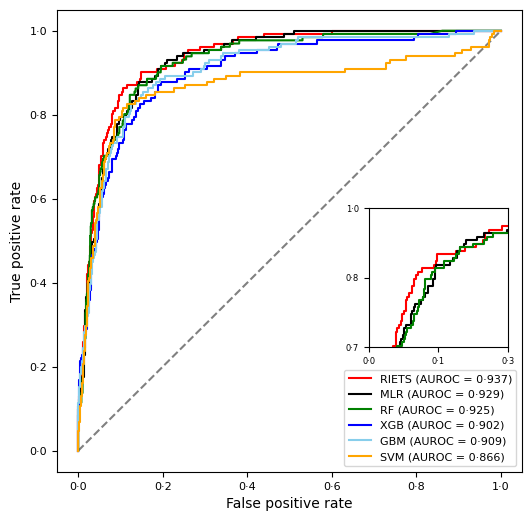

In [55]:
model_names = ['RIETS', 'MLR', 'RF', 'XGB', 'GBM', 'SVM']
model_names2 = ['RIETS', 'MLR', 'RF']

colors = {
    'MLR': 'black',
    'RF': 'green',
    'RIETS': 'red',
    'XGB': 'blue',
    'GBM': 'skyblue',
    'SVM': 'orange'
}

for i in numbers:
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot([0, 1], [0, 1], '--', color='gray')

    for model_name in model_names:
        curve = eval(f"{model_name}_curve_{i}")
        area = f"{curve[2]:.3f}".replace('.', '·')  # Replace decimal point with central dot
        ax.plot(curve[0], curve[1], color=colors[model_name], label=f'{model_name} (AUROC = {area})')

    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')

    # Set the formatter functions for the x and y axes of the inset plot
    ax.xaxis.set_major_formatter(FuncFormatter(format_tick))
    ax.yaxis.set_major_formatter(FuncFormatter(format_tick))
    
    # Modify the ticks for the outer box
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    
    ax.tick_params(axis='both', which='both', labelsize=8)
    
    # ax.set_title(f"AUROC curve of ML and DL models for variableSet {i}")
    ax.legend(loc='lower right', fontsize=8)
    
    # Add the zoomed-in subimage plot
    ax_inset = inset_axes(ax, width="30%", height="30%", loc='center right',bbox_to_anchor=(0, -0.08, 1, 1), bbox_transform=ax.transAxes, borderpad=1)
    for model_name in model_names2:
        curve = eval(f"{model_name}_curve_{i}")
        ax_inset.plot(curve[0], curve[1], color=colors[model_name])
    
    ax_inset.set_xlim(0, 0.3)
    ax_inset.set_ylim(0.7, 1)

    # Set the formatter functions for the x and y axes of the inset plot
    ax_inset.xaxis.set_major_formatter(FuncFormatter(format_tick))
    ax_inset.yaxis.set_major_formatter(FuncFormatter(format_tick))

    ax_inset.set_xticks([0, 0.15, 0.3])
    ax_inset.set_yticks([0.7, 0.85, 1])
    ax_inset.tick_params(axis='both', which='both', labelsize=6)
    
    plt.savefig(f'../Result/Figure_3A_ROC_Plot.png', dpi=600)
    plt.show()

### Calibration Plots

In [56]:
def CalibrationPlot(models, model_names, X_test, Y_test, n_bins=None, DeepLearning=None, colors=None):
    if DeepLearning is None:
        DeepLearning = [False] * len(models)
    if n_bins is None:
        n_bins=5
    plt.figure(figsize=(6, 6))

    for model, model_name, is_deep_learning in zip(models, model_names, DeepLearning):
        if is_deep_learning:
            Y_pred_prob = model.predict(X_test)
        else:
            Y_pred_prob = model.predict_proba(X_test)[:, 1]

        observed_probs, predicted_probs = calibration_curve(Y_test, Y_pred_prob, n_bins=n_bins, strategy='uniform')

        # Calculate ICI
        ici = compute_ici(observed_probs, predicted_probs)
        
        plt.plot(predicted_probs, observed_probs, marker='o', linewidth=1, label=f'{model_name} (ICI = {ici:.3f})', color=colors[model_name])

        # Calculate the confidence intervals for each bin
        bin_edges = np.linspace(0, 1, n_bins + 1)
        bin_width = np.diff(bin_edges)
        
        Y_bin = np.digitize(Y_pred_prob, bin_edges) - 1

        non_empty_bins = [i for i in range(n_bins) if len(Y_test[np.flatnonzero(Y_bin == i)]) > 0]
        conf_intervals = [proportion_confint(sum((Y_test[np.flatnonzero(Y_bin == i)] == 1)), len(Y_test[np.flatnonzero(Y_bin == i)]), method='wilson', alpha=0.1) for i in non_empty_bins]
        lower_bounds = [conf_interval[0] for conf_interval in conf_intervals]
        upper_bounds = [conf_interval[1] for conf_interval in conf_intervals]

        # Add the shaded areas for confidence intervals
        plt.fill_between(np.array(predicted_probs)[non_empty_bins], lower_bounds, upper_bounds, alpha=0.1, color=colors[model_name])

    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
    ax = plt.gca()
    # Set the formatter functions for the x and y axes of the inset plot
    ax.xaxis.set_major_formatter(FuncFormatter(format_tick))
    ax.yaxis.set_major_formatter(FuncFormatter(format_tick))
    
    # Modify the ticks for the outer box
    ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Probability')
    plt.legend()
    plt.savefig(f'../Result/Figure_3B_Calibration_Plot.png', dpi=600)
    plt.show()

In [57]:
from sklearn.linear_model import LogisticRegression

def compute_ici(observed_probs, predicted_probs):
    # Kernel Density Estimation of the predicted probabilities
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(predicted_probs.reshape(-1, 1))
    
    # Density function of the predicted probabilities
    density_function = lambda x: np.exp(kde.score_samples(np.array([x]).reshape(-1, 1)))
    
    # ICI as a weighted average of absolute differences
    ici_func = lambda x: np.abs(x - np.interp(x, predicted_probs, observed_probs)) * density_function(x)
    
    # Integration over the predicted probabilities
    ici, _ = quad(ici_func, 0, 1, limit=100)
    
    return ici

def calculate_calibration(observed_probability, predicted_probability):
    # Calibration-in-the-large
    C = np.mean(observed_probability) - np.mean(predicted_probability)

    # Calibration-slope
    S = np.cov(observed_probability, predicted_probability)[0, 1] / np.var(predicted_probability)

    return C, S

def bootstrap_CI(observed_probability, predicted_probability, n_bootstrap=100):
    C_values = []
    S_values = []

    n = len(observed_probability)
    for _ in range(n_bootstrap):
        indices = np.random.choice(n, size=n, replace=True)
        observed_probability_sample = observed_probability[indices]
        predicted_probability_sample = predicted_probability[indices]

        C, S = calculate_calibration(observed_probability_sample, predicted_probability_sample)
        
        C_values.append(C)
        S_values.append(S)

    C_values.sort()
    S_values.sort()

    lower = int(0.025 * n_bootstrap)  # 2.5 percentile
    upper = int(0.975 * n_bootstrap)  # 97.5 percentile
    median = int(0.5 * n_bootstrap)  # 50 percentile

    return [C_values[median], C_values[lower], C_values[upper]], [S_values[median], S_values[lower], S_values[upper]]

def calibration_table(models, model_names, X_test, Y_test, n_bins=None, DeepLearning=None, colors=None):
    if DeepLearning is None:
        DeepLearning = [False] * len(models)
    if n_bins is None:
        n_bins=5

    results = []

    for model, model_name, is_deep_learning in zip(models, model_names, DeepLearning):
        if is_deep_learning:
            Y_pred_prob = model.predict(X_test)
        else:
            Y_pred_prob = model.predict_proba(X_test)[:, 1]

        observed_probs, predicted_probs = calibration_curve(Y_test, Y_pred_prob, n_bins=n_bins, strategy='uniform')

        # Calculate ICI, CITL, and slope
        ici = compute_ici(observed_probs, predicted_probs)
        citl, slope = bootstrap_CI(observed_probs, predicted_probs)        
        
        citl_CI = f'{citl[0]:.3f} [{citl[1]:.3f}-{citl[2]:.3f}]'
        slope_CI = f'{slope[0]:.3f} [{slope[1]:.3f}-{slope[2]:.3f}]'
        results.append({
            'Model': model_name,
            'ICI' : ici,
            'CITL': citl_CI,
            'Slope': slope_CI
        })

    df = pd.DataFrame(results)
    df = df.round(3) 
    df.to_excel("../Result/calibration_results.xlsx", index=False)
    return df        

In [58]:
def CalibrationPlot(models, model_names, X_test, Y_test, n_bins=None, DeepLearning=None, colors=None):
    if DeepLearning is None:
        DeepLearning = [False] * len(models)
    if n_bins is None:
        n_bins=5
    plt.figure(figsize=(6, 6))

    for model, model_name, is_deep_learning in zip(models, model_names, DeepLearning):
        if is_deep_learning:
            Y_pred_prob = model.predict(X_test)
        else:
            Y_pred_prob = model.predict_proba(X_test)[:, 1]

        observed_probs, predicted_probs = calibration_curve(Y_test, Y_pred_prob, n_bins=n_bins, strategy='uniform')

        # Calculate ICI
        ici = compute_ici(observed_probs, predicted_probs)
        
        # plt.plot(predicted_probs, observed_probs, marker='o', linewidth=1, label=f'{model_name} (ICI = {ici:.3f}) (CITL: {citl[0]:.3f} [{citl[1]:.3f}-{citl[2]:.3f}]) (Slope: {slope[0]:.3f} [{slope[1]:.3f}-{slope[2]:.3f}])', color=colors[model_name])
        plt.plot(predicted_probs, observed_probs, marker='o', linewidth=1, label=f'{model_name} (ICI = {ici:.3f})', color=colors[model_name])

        # Calculate the confidence intervals for each bin
        bin_edges = np.linspace(0, 1, n_bins + 1)
        bin_width = np.diff(bin_edges)
        
        Y_bin = np.digitize(Y_pred_prob, bin_edges) - 1

        non_empty_bins = [i for i in range(n_bins) if len(Y_test[np.flatnonzero(Y_bin == i)]) > 0]
        conf_intervals = [proportion_confint(sum((Y_test[np.flatnonzero(Y_bin == i)] == 1)), len(Y_test[np.flatnonzero(Y_bin == i)]), method='wilson', alpha=0.1) for i in non_empty_bins]
        lower_bounds = [conf_interval[0] for conf_interval in conf_intervals]
        upper_bounds = [conf_interval[1] for conf_interval in conf_intervals]

        # Add the shaded areas for confidence intervals
        plt.fill_between(np.array(predicted_probs)[non_empty_bins], lower_bounds, upper_bounds, alpha=0.1, color=colors[model_name])

    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
    ax = plt.gca()
    # Set the formatter functions for the x and y axes of the inset plot
    ax.xaxis.set_major_formatter(FuncFormatter(format_tick))
    ax.yaxis.set_major_formatter(FuncFormatter(format_tick))
    
    # Modify the ticks for the outer box
    ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Probability')
    plt.legend()
    plt.savefig(f'../Result/Figure_3B_Calibration_Plot.png', dpi=600)
    plt.show()

50/50 [==============================] - 0s 469us/step


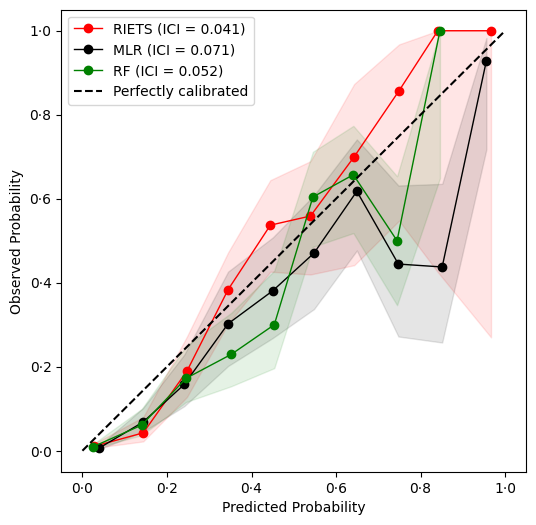

In [59]:
exec(f'Models = [DNN_model_{i}, MLR_model_{i}, RF_model_{i}]')
model_names = ['RIETS', 'MLR', 'RF']
DeepLearning = [True, False, False]
CalibrationPlot(Models, model_names, X40_test, Y40_test, n_bins=10, DeepLearning=DeepLearning, colors=colors)

In [60]:
exec(f'Models = [DNN_model_{i}, MLR_model_{i}, RF_model_{i}, XGB_model_{i}, GBM_model_{i}, SVM_model_{i}]')
model_names = ['RIETS', 'MLR', 'RF', 'XGB', 'GBM', 'SVM']
DeepLearning = [True, False, False, False, False, False]
calibration_table(Models, model_names, X40_test, Y40_test, n_bins=10, DeepLearning=DeepLearning, colors=colors)

50/50 [==============================] - 0s 469us/step


The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


,Model,ICI,CITL,Slope
0,RIETS,0.041,0.035 [-0.005-0.081],1.316 [1.177-1.491]
1,MLR,0.071,-0.119 [-0.204--0.051],0.858 [0.552-1.194]
2,RF,0.052,-0.064 [-0.114-0.010],1.186 [0.777-1.618]
3,XGB,0.103,-0.167 [-0.276--0.087],0.678 [0.336-0.942]
4,GBM,0.112,-0.095 [-0.212-0.019],0.421 [-0.003-0.670]
5,SVM,0.073,-0.047 [-0.156-0.026],0.641 [0.273-1.076]


### Decision Curve Analysis Plot

In [61]:
from typing import Literal, Optional, Union
from pandas import Series
from numpy import ndarray as NDArray
from numpy import linspace, divide, zeros_like, ones_like
from sklearn.metrics import roc_curve
import numpy as np 
from statkit.decision import NetBenefitDisplay

def binary_classification_thresholds(y_true, y_pred, thresholds):
    tns, fps, fns, tps = [], [], [], []

    for threshold in thresholds:
        y_pred_class = (y_pred >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_class).ravel()
        tns.append(tn)
        fps.append(fp)
        fns.append(fn)
        tps.append(tp)

    return np.array(tns), np.array(fps), np.array(fns), np.array(tps)

class CustomNetBenefitDisplay(NetBenefitDisplay):
    def plot(self, show_references: bool = True, ax=None, colors=None):
        """
        Args:
            show_references: Show oracle (requires prevalence) and no
                action/treatment/intervention reference curves.
            ax: Optional axes object to plot on. If `None`, a new figure and axes is
                created.
            colors: Optional dictionary to define colors for the curves.
                Example: {'Model': 'blue', 'Always act': 'green', 'Never act': 'red', 'Oracle': 'orange'}
        """
        if colors is None:
            colors = {}

        if ax is None:
            _, ax = plt.subplots()
        self.ax_ = ax
        self.figure_ = ax.figure

        ax.plot(
            self.threshold_probability, self.net_benefit, "-", label=self.estimator_name, color=colors.get(self.estimator_name)
        )
        if show_references:
            ax.plot(
                self.threshold_probability,
                self.net_benefit_action,
                ":",
                label="Always treat",
                color=colors.get('Always treat'),
            )
            ax.plot(
                self.threshold_probability,
                self.net_benefit_noop,
                "-.",
                label="Never treat",
                color=colors.get('Never treat'),
            )

            if self.oracle is not None:
                ax.plot([0, 1], [self.oracle, self.oracle], "--", label="Oracle", color=colors.get('Oracle'))

        ylabel = "Net benefit"
        if self.benefit_type == "action":
            ylabel = "Net benefit (action)"
        if self.benefit_type == "noop":
            ylabel = "Net benefit (no-action)"
        if self.benefit_type == "overall":
            ylabel = "Overall net benefit"

        ax.set(xlabel="Threshold probability", ylabel=ylabel)
        margin = 0.05
        ax.set_ylim([-margin, 1 + margin])
        ax.legend(loc="upper right", frameon=False)

        return self
    
    @classmethod
    def from_predictions(
        cls,
        y_true,
        y_pred,
        benefit_type: Literal["action", "noop", "overall"] = "action",
        thresholds: int = 100,
        name: Optional[str] = None,
        show_references: bool = True,
        ax=None,
        colors=None,  
    ):        
        """Make a net benefit plot from true and predicted labels.

        Args:
            y_true: Binary ground truth label (1: positive, 0: negative class).
            y_pred: Predicted class labels.
            benefit_type: Type of net benefit curve. `"action"`: net benefit of
                treatment/intervention/action; `"noop`: net benefit of no
                treatment/intervention/action; `"overall"`: overall net benefit (see
                `overall_net_benefit`).
            show_references: Show oracle (requires prevalence) and no
                action/treatment/intervention reference curves.
            thresholds: When an array, evaluate net benefit at these coordinates (the
                probability thresholds). When an int, the number of x coordinates.
            ax: Optional axes object to plot on. If `None`, a new figure and axes is
                created.

        Example:
            ```python
            from sklearn.datasets import make_blobs
            from sklearn.linear_model import LogisticRegression
            from statkit.decision import NetBenefitDisplay

            centers = [[0, 0], [1, 1]]
            X_train, y_train = make_blobs(
                centers=centers, cluster_std=1, n_samples=20, random_state=5
            )
            X_test, y_test = make_blobs(
                centers=centers, cluster_std=1, n_samples=20, random_state=1005
            )

            clf = LogisticRegression(random_state=5).fit(X_train, y_train)
            y_pred_base = clf.predict_proba(X_test)[:, 1]
            NetBenefitDisplay.from_predictions(y_test, y_pred_base, name='Logistic Regression')
            ```
        """
        if benefit_type == "action":
            oracle = cls.net_benefit_oracle(y_true, action=True)
            thresholds, benefit = cls.net_benefit(y_true, y_pred, thresholds)
            benefit_action = cls.net_benefit_action(y_true, thresholds, action=True)
            benefit_noop = zeros_like(benefit)

        elif benefit_type == "noop":
            oracle = cls.net_benefit_oracle(y_true, action=False)
            thresholds, benefit = cls.net_benefit(y_true, y_pred, thresholds, action=False)
            benefit_noop = cls.net_benefit_action(y_true, thresholds, action=False)
            benefit_action = zeros_like(benefit)

        elif benefit_type == "overall":
            oracle = 1.0
            thresholds, benefit = cls.overall_net_benefit(y_true, y_pred, thresholds)
            benefit_action = cls.net_benefit_action(y_true, thresholds, action=True)
            benefit_noop = cls.net_benefit_action(y_true, thresholds, action=False)

        return cls(
            thresholds,
            benefit,
            benefit_action,
            benefit_noop,
            benefit_type,
            oracle,
            estimator_name=name,
        ).plot(ax=ax, show_references=show_references, colors=colors) 
    
    def net_benefit_oracle(y_true, action: bool = True) -> float:
        """Net benefit of omniscient strategy, i.e., a hypothetical perfect predictor."""
        if action:
            return y_true.mean()
        return 1 - y_true.mean()
    
    def net_benefit_action(y_true, thresholds, action: bool = True):
        """Net benefit of always doing an action/intervention/treatment.

        Args:
            action: When `False`, invert positive label in `y_true`.
        """
        if action:
            loss_over_profit = divide(
                thresholds,
                1 - thresholds,
                where=thresholds < 1,
                out=1e9 * ones_like(thresholds),
            )
            return y_true.mean() - (1 - y_true.mean()) * loss_over_profit
        profit_over_loss = divide(
            1 - thresholds,
            thresholds,
            where=thresholds != 0,
            out=1e9 * ones_like(thresholds),
        )
        return 1 - y_true.mean() - y_true.mean() * profit_over_loss

    def net_benefit(
    y_true: Union[Series, NDArray],
    y_pred: Union[Series, NDArray],
    thresholds=100,
    action: bool = True,
    ):
        """Net benefit of taking an action using a model's predictions.

        Args:
            y_true: Binary ground truth label (1: positive, 0: negative class).
            y_pred: Probability of positive class label.
            thresholds: When an array, evaluate net benefit at these coordinates (the
                probability thresholds). When an int, the number of x coordinates.
            action: When `True` (`False`), estimate net benefit of taking (not taking) an
                action/intervention/treatment.

        Returns:
            thresholds: Probability threshold of prediction a positive class.
            benefit: The net benefit corresponding to the thresholds.

        References:
            [1]: Vickers-Elkin. "Decision curve analysis: a novel method for evaluating
            prediction models." Medical Decision Making 26.6 (2006): 565-574.
            [2]: Rousson-Zumbrunn. "Decision curve analysis revisited: overall net
            benefit, relationships to ROC curve analysis, and application to case-control
            studies." BMC medical informatics and decision making 11.1 (2011): 1–9.
        """
        if set(y_true.astype(int)) != {0, 1}:
            raise ValueError(
                "Decision curve analysis only supports binary classification (with labels 1 and 0)."
            )

        if isinstance(thresholds, int):
            thresholds = linspace(0, 1, num=thresholds)

        N = len(y_true)
        tns, fps, fns, tps = binary_classification_thresholds(y_true, y_pred, thresholds)
        
        if action:
            loss_over_profit = divide(
                thresholds, 1 - thresholds, where=thresholds < 1, out=zeros_like(thresholds)
            )

            benefit = tps / N - fps / N * loss_over_profit
        else:
            # Invert 0<-->1 so that true positives are true negatives, and false positives
            # are false negatives.
            profit_over_loss = divide(
                1 - thresholds,
                thresholds,
                where=thresholds != 0,
                out=zeros_like(thresholds),
            )
            benefit = tns / N - fns / N * profit_over_loss
        return thresholds, benefit

    def overall_net_benefit(y_true, y_pred, n_thresholds: int = 100):
        """Net benefit combining both taking and not-taking action."""
        thresholds_action, benefit_action = net_benefit(
            y_true, y_pred, n_thresholds, action=True
        )
        _, benefit_no_action = net_benefit(y_true, y_pred, thresholds_action, action=False)
        return thresholds_action, benefit_action + benefit_no_action
    
# Define the formatter function
def format_tick2(x, pos):
    return f"{x:.2f}".replace('.', '·')

In [62]:
def PlotDecisionCurveAnalysis(models, model_names, X_test, Y_test, DeepLearning=None, colors=None):
    thresholds = np.linspace(0, 1, 100)
    plt.figure(figsize=(6, 6))
    if DeepLearning is None:
        DeepLearning = [False] * len(models)
    for model, model_name, is_deep_learning in zip(models, model_names, DeepLearning):
        if is_deep_learning:
            exec(f'Y_pred_{model_name} = model.predict(X_test)')
            exec(f'net_benefit_display = CustomNetBenefitDisplay.from_predictions(Y_test, Y_pred_{model_name}, name=model_name, show_references=True, colors=colors, ax=plt.gca())')    
        else:
            exec(f'Y_pred_{model_name} = model.predict_proba(X_test)[:, 1]')
            exec(f'net_benefit_display = CustomNetBenefitDisplay.from_predictions(Y_test, Y_pred_{model_name}, name=model_name, show_references=False, colors=colors, ax=plt.gca())')
        plt.ylim([-0.1, 0.12])
        
        # Collect the existing legend elements
        legend_elements = plt.gca().legend().get_lines()
        legend_labels = [elem.get_label() for elem in legend_elements]
        
        # Desired order
        order = {'RIETS': 0, 'MLR': 1, 'RF': 2, 'XGB': 3, 'GBM': 4, 'SVM': 5, 'Always treat': 6, 'Never treat': 7, 'Oracle': 8}
        
        # Sort the elements and labels by the desired order
        sorted_elements_labels = sorted(zip(legend_elements, legend_labels), key=lambda x: order[x[1]])
        sorted_elements, sorted_labels = zip(*sorted_elements_labels)
        
        # Update the legend with the new order
        plt.legend(handles=sorted_elements, labels=sorted_labels, loc='lower right', fontsize=7)
    
    ax = plt.gca()
    # Set the formatter functions for the x and y axes of the inset plot
    ax.xaxis.set_major_formatter(FuncFormatter(format_tick))
    ax.yaxis.set_major_formatter(FuncFormatter(format_tick2))
    
    # Modify the ticks for the outer box
    ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticks([-0.1, -0.08, -0.06, -0.04, -0.02, 0, 0.02, 0.04, 0.06, 0.08, 0.1])    
    
    # Set Y label to Net Benefit 
    plt.ylabel('Net benefit')
    
    #Save the figure
    plt.savefig('../Result/Figure_3C_Decision_Curve_Analysis_Plot.png', dpi=600)
    plt.show()

50/50 [==============================] - 0s 449us/step


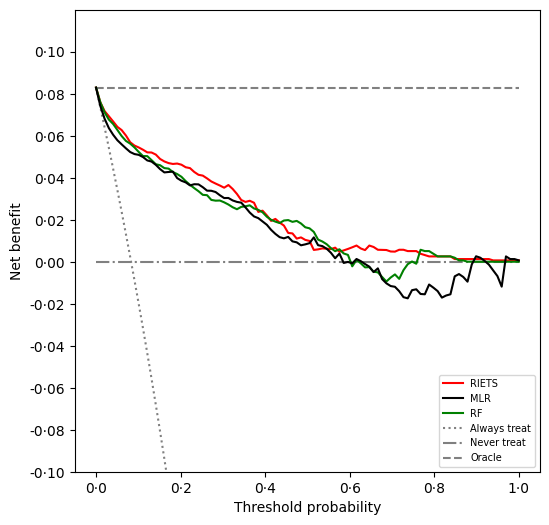

In [63]:
colors = {'Always treat': 'gray',
          'Never treat': 'gray',
          'Oracle': 'gray',
          'MLR': 'black',
          'RF': 'green',
          'RIETS': 'red',
          'XGB': 'blue',
          'GBM': 'skyblue',
          'SVM': 'orange'}

exec(f'Models = [DNN_model_{i}, RF_model_{i}, MLR_model_{i}]')
model_names = ['RIETS', 'RF', 'MLR']
DeepLearning = [True, False, False]
PlotDecisionCurveAnalysis(Models, model_names, X40_test, Y40_test, DeepLearning=DeepLearning, colors=colors)

50/50 [==============================] - 0s 490us/step


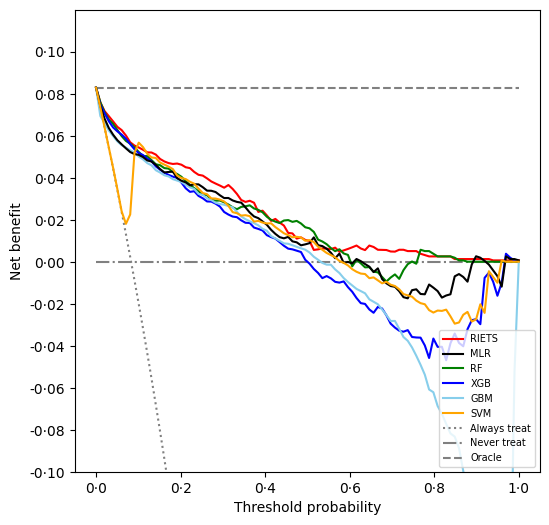

In [64]:
exec(f'Models = [DNN_model_{i}, RF_model_{i}, XGB_model_{i}, GBM_model_{i}, MLR_model_{i}, SVM_model_{i}]')
model_names = ['RIETS', 'RF', 'XGB', 'GBM', 'MLR', 'SVM']
DeepLearning = [True, False, False, False, False, False]
PlotDecisionCurveAnalysis(Models, model_names, X40_test, Y40_test, DeepLearning=DeepLearning, colors=colors)

### Net Reclassification Impact 

In [65]:
def reclassification_plot(X_test, Y_test, new_model, old_model, name1=None, name2=None, cutoff_newmodel=None, cutoff_oldmodel=None, DeepLearning=None):
    probas_NEW = new_model.predict(X_test)
    probas_OLD = old_model.predict_proba(X_test)[:, 1]
        
    plt.figure(figsize=(6, 6))

    plt.scatter(probas_OLD[Y_test == 0], probas_NEW[Y_test == 0], color='b', label='Non-Severe')
    plt.scatter(probas_OLD[Y_test == 1], probas_NEW[Y_test == 1], color='r', label='Severe')

    plt.plot([0, 1], [0, 1], '--', color='gray')

    # Add cut-off lines
    if cutoff_newmodel is not None:
        plt.axhline(y=cutoff_newmodel, color='gray', linestyle=':', label=f'{name1} cut-off')
    if cutoff_oldmodel is not None:
        plt.axvline(x=cutoff_oldmodel, color='gray', linestyle='--', label=f'{name2} cut-off')

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel(f'{name2} Predicted Probability')
    plt.ylabel(f'{name1} Predicted Probability')
    
    ax = plt.gca()
    # Set the formatter functions for the x and y axes of the inset plot
    ax.xaxis.set_major_formatter(FuncFormatter(format_tick))
    ax.yaxis.set_major_formatter(FuncFormatter(format_tick))
    
    # Modify the ticks for the outer box
    ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    
    # plt.title(f'Reclassification Plot for {name1} and {name2} model')
    plt.legend(loc='lower right')
    plt.savefig(f'../Result/S_Fig3_Reclassification_Plots_{name1}_{name2}.png', dpi=600)
    plt.show()

50/50 [==============================] - 0s 469us/step


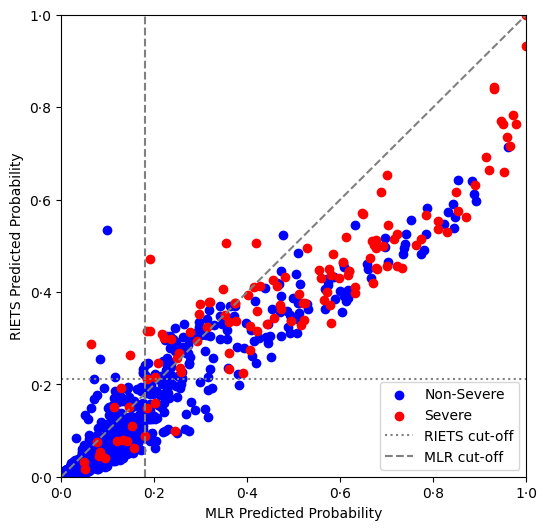

In [66]:
#DNN and MLR
i=40
exec(f"reclassification_plot(X{i}_test, Y{i}_test, DNN_model_{i}, MLR_model_{i}, 'RIETS', 'MLR', 0.212, 0.180)")

50/50 [==============================] - 0s 449us/step


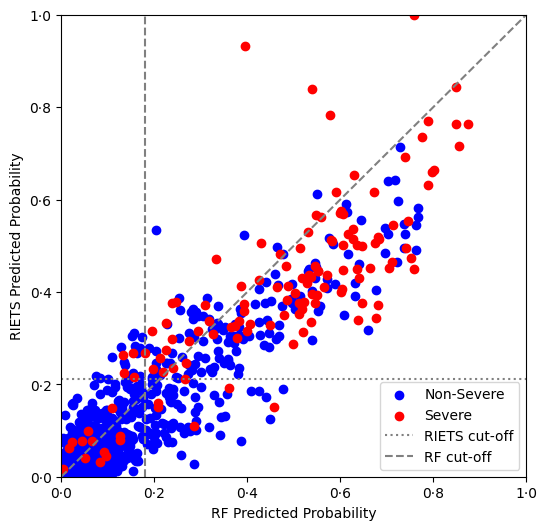

In [67]:
exec(f"reclassification_plot(X{i}_test, Y{i}_test, DNN_model_{i}, RF_model_{i}, 'RIETS', 'RF', 0.212, 0.181)")

50/50 [==============================] - 0s 449us/step


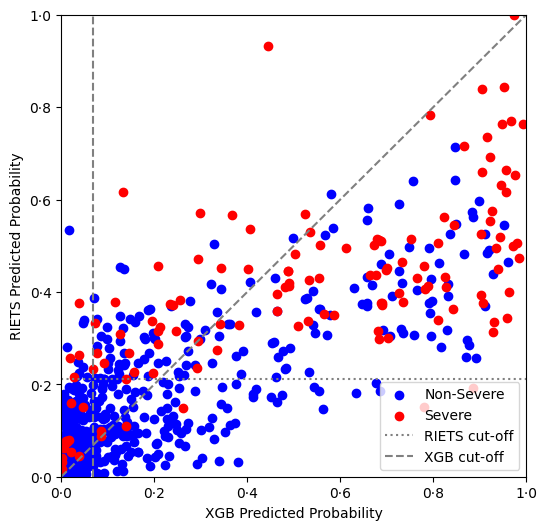

In [68]:
exec(f"reclassification_plot(X{i}_test, Y{i}_test, DNN_model_{i}, XGB_model_{i}, 'RIETS', 'XGB', 0.212, 0.069)")

50/50 [==============================] - 0s 469us/step


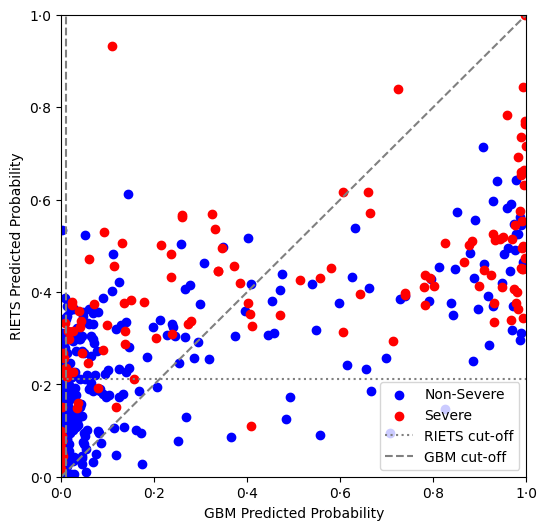

In [69]:
exec(f"reclassification_plot(X{i}_test, Y{i}_test, DNN_model_{i}, GBM_model_{i}, 'RIETS', 'GBM', 0.212, 0.011)")

50/50 [==============================] - 0s 490us/step


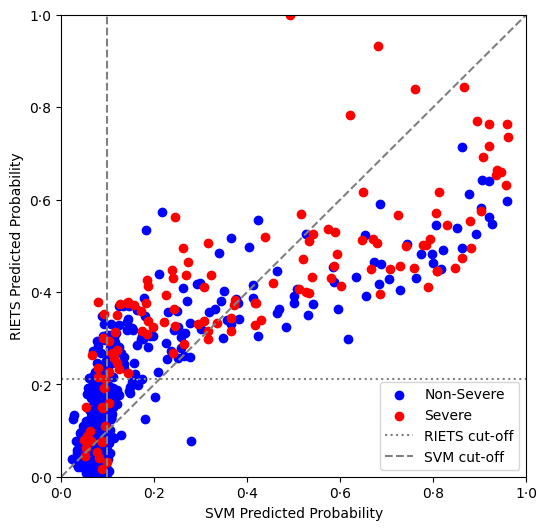

In [70]:
exec(f"reclassification_plot(X{i}_test, Y{i}_test, DNN_model_{i}, SVM_model_{i}, 'RIETS', 'SVM', 0.212, 0.098)")

In [44]:
def Binary_NRI(new_model, old_model, X_test, Y_test, new_model_cut=None, old_model_cut=None, DeepLearning=None):
    #Random Forest
    probas_NEW = new_model.predict(X_test).ravel()
    probas_OLD = old_model.predict_proba(X_test)[:, 1]
    
    n_cases = np.sum(Y_test == 1)
    n_controls = np.sum(Y_test == 0) 

    up_cases, down_cases, up_controls, down_controls = 0, 0, 0, 0

    up_cases += np.sum((probas_NEW[Y_test == 1] > new_model_cut) & (probas_OLD[Y_test == 1] <= old_model_cut))
    down_cases += np.sum((probas_NEW[Y_test == 1] <= new_model_cut) & (probas_OLD[Y_test == 1] > old_model_cut))
    up_controls += np.sum((probas_NEW[Y_test == 0] > new_model_cut) & (probas_OLD[Y_test == 0] <= old_model_cut))
    down_controls += np.sum((probas_NEW[Y_test == 0] <= new_model_cut) & (probas_OLD[Y_test == 0] > old_model_cut))

    nri_plus = (up_cases - down_cases) / n_cases
    nri_minus = (down_controls - up_controls) / n_controls
    nri = nri_plus + nri_minus
    
    return nri, nri_plus, nri_minus

In [45]:
DeepLearning = [False, False, False, False, False]
Models = ['RF', 'MLR', 'XGB', 'GBM', 'SVM']
nri_results = []
for model in Models:
    exec(f'nri_{model}_result = Binary_NRI(DNN_model_{i}, {model}_model_{i}, X{i}_test, Y{i}_test, new_model_cut=DNN_threshold_YI_{i}, old_model_cut={model}_threshold_YI_{i}, DeepLearning=DeepLearning)')
    nri_results.append(eval(f'nri_{model}_result'))

# Create a table (DataFrame) to display the results
nri_table = pd.DataFrame(
    {
        "NRI": [np.round(nri_result[0],4) for nri_result in nri_results],
        "NRI+ (Severe)": [np.round(nri_result[1],4) for nri_result in nri_results],
        "NRI- (Non-Severe)": [np.round(nri_result[2],4) for nri_result in nri_results],
    },
    index=[f"DNN vs {model}" for model in Models],
)
nri_table.to_csv('../Result/nri_results.csv')
nri_table

50/50 [==============================] - 0s 469us/step


,NRI,NRI+ (Severe),NRI- (Non-Severe)
DNN vs RF,0.0104,0.0076,0.0028
DNN vs MLR,0.0276,-0.0076,0.0352
DNN vs XGB,0.0685,0.0382,0.0304
DNN vs GBM,0.0408,0.0153,0.0255
DNN vs SVM,0.0432,0.0763,-0.0331


### Interpretable AI & Explainable AI 

In [46]:
#Code for extracting the feature importance of each feature
def Shapley_extractor(shap_values, feature_names, col_name):
    index = feature_names.index(col_name)
    shap_values_0 = shap_values[0]
    shap_value_0 = np.mean(np.abs(shap_values_0[:, index]))

    if len(shap_values) > 1:
        shap_values_1 = shap_values[1]
        shap_value_1 = np.mean(np.abs(shap_values_1[:, index]))
        return shap_value_0 + shap_value_1
    else:
        return shap_value_0

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


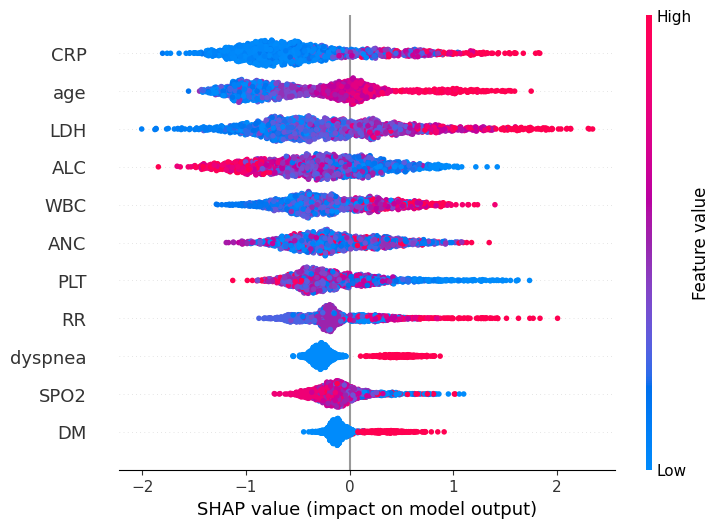

In [47]:
XGB_model = XGBClassifier(colsample_bytree=0.4, eta=0.2, gamma=0.75, learning_rate=0.45, max_depth=18, min_child_weight=14, nthread=6).fit(DevelopmentSet[Variables_40], DevelopmentSet.Severe)
shap.initjs()
explainer_XGB = shap.Explainer(XGB_model)
shap_values_XGB = explainer_XGB(ValidationSet[Variables_40])
shap.plots.beeswarm(shap_values_XGB, max_display=11, order=shap.Explanation.abs.mean(0))

# shap_values_dict = {}
# for variable in Variables_40:
#     shap_val = Shapley_extractor(shap_values, Variables_40, variable)
#     shap_values_dict[variable.upper()] = shap_val

# # Update feature_names with Shapley values
# updated_feature_names = [f"{name.upper()}: {shap_values_dict[name.upper()]:.4f}" for name in Variables_40]
# plt.title('XGB based Shapley Summary Plot', fontsize=15)
# shap.summary_plot(shap_values, X40_test, show=False, feature_names=updated_feature_names)
# plt.show()

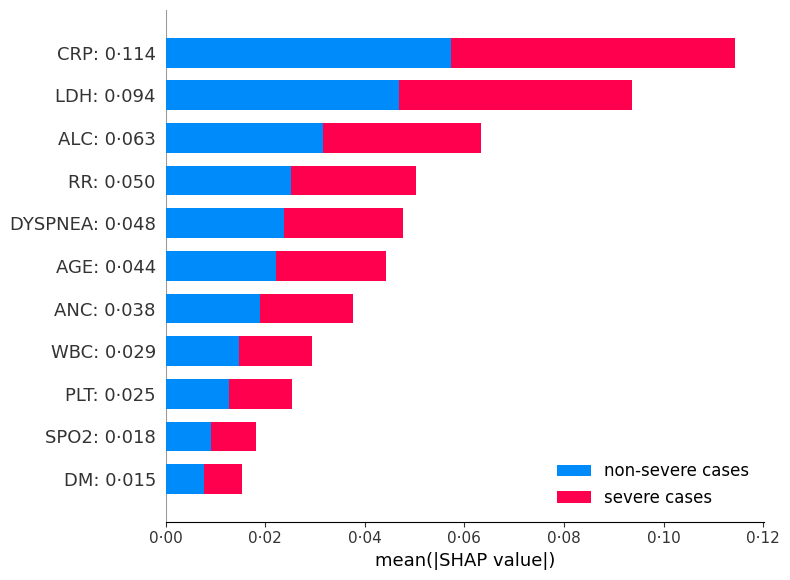

In [48]:
RF_model = RandomForestClassifier(criterion='entropy', max_depth=25, max_features='sqrt', min_samples_split=5, n_estimators = 299, n_jobs=-1).fit(X40_train, Y40_train)
shap.initjs()
explainer_2 = shap.TreeExplainer(RF_model)
shap_values_2 = explainer_2.shap_values(X40_test)
shap_values_dict = {}
for variable in Variables_40:
    shap_val = Shapley_extractor(shap_values_2, Variables_40, variable)
    shap_values_dict[variable.upper()] = shap_val

# Update feature_names with Shapley values
updated_feature_names = [f"{name.upper()}: {shap_values_dict[name.upper()]:.3f}".replace('.', '·') for name in Variables_40]
# plt.title('Shapley Summary Plot', fontsize=15)
shap.summary_plot(shap_values_2, X40_test, show=False, feature_names=updated_feature_names, class_names=['non-severe cases', 'severe cases'])
plt.xlabel('mean(|SHAP value|)')
ax = plt.gca()

# Set the formatter functions for the x and y axes of the inset plot
ax.xaxis.set_major_formatter(FuncFormatter(format_tick2))

# Modify the ticks for the outer box
ax.set_xticks([0.0, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12])

plt.savefig('../Result/S_Figure4_RFbased_Shapley_Summary_Plot.png', dpi=600)
plt.show()

In [49]:
# shap.initjs()
# # Summarize background data using shap.kmeans()
# background_data = shap.kmeans(X40_train, 1000) 

# explainer = shap.KernelExplainer(DNN_model_40.predict, background_data)
# shap_values = explainer.shap_values(X40_test,nsamples=1000)

In [50]:
# # Convert the SHAP values to a DataFrame
# shap_df = pd.DataFrame(shap_values[0], columns=updated_feature_names)

# # Save the DataFrame as a CSV file
# shap_df.to_csv('../Result/Shap_values_DNN_KernelExplainer.csv', index=False)

In [51]:
combined_shap_values = pd.read_csv('../Result/Shap_values_DNN_KernelExplainer.csv')

In [52]:
shap_values = [combined_shap_values.values,-combined_shap_values.values]


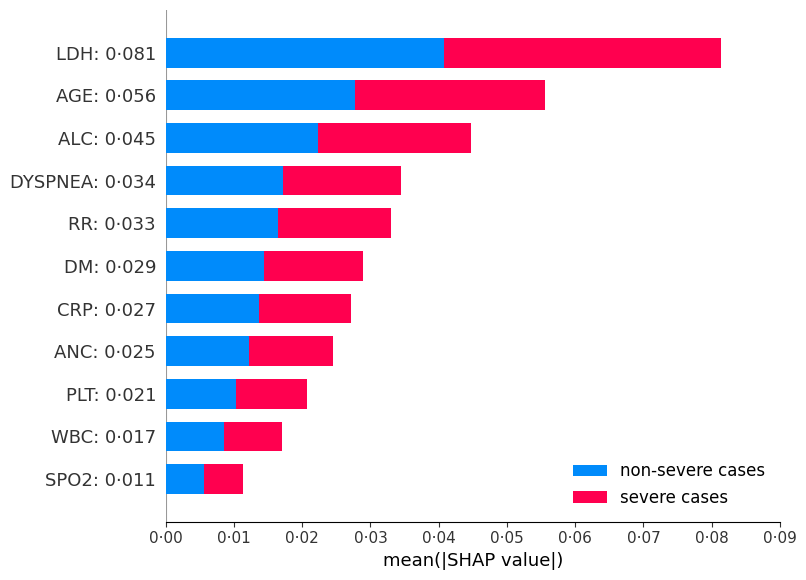

In [53]:
shap_values_dict = {}
for variable in Variables_40:
    shap_val = Shapley_extractor(shap_values, Variables_40, variable)
    shap_values_dict[variable.upper()] = shap_val

# Update feature_names with Shapley values
updated_feature_names = [f"{name.upper()}: {shap_values_dict[name.upper()]:.3f}".replace('.', '·') for name in Variables_40]
# plt.title('Shapley Summary Plot for DNN model', fontsize=15)
shap.summary_plot(shap_values, X40_test, show=False, feature_names=updated_feature_names, plot_type='bar', class_names=['non-severe cases', 'severe cases'])
plt.xlabel('mean(|SHAP value|)')
ax = plt.gca()
# Set the formatter functions for the x and y axes of the inset plot
ax.xaxis.set_major_formatter(FuncFormatter(format_tick2))

# Modify the ticks for the outer box
ax.set_xticks([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])
plt.savefig('../Result/Figure_4_Shapley_Summary_Plot.png', dpi=600)
plt.show()